## Validate Dropout implementation

In [1]:
# dependencies
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torch.optim as optim
import time

from implementation.dropout import Dropout
from utils.tensor_loader import FastTensorDataLoader
from utils.plots import plot_dropout_histories, summarize_metrics, plot_neuron_correlations
from utils.monte_carlo import evaluate_mc_dropout, plot_mc_uncertainty_analysis, compare_dropout_rates_mc, visualize_uncertainty_examples, create_mc_summary_table, compare_all_models_mc

np.random.seed(42)
torch.manual_seed(42)

## Simple Distribution Validation
Test to see if both standard and inverted dropout show expected results

In [2]:
p = 0.5
input_tensor = torch.ones(500, 500) 

# inverted
drop_inv = Dropout(p=p, mode="inverted")
drop_inv.train()
out_inv = drop_inv(input_tensor)
# 50% is dropped. The mean would be 0.5, but scaling should make it close to 1
print(f"Inverted (Train) Mean: {out_inv.mean():.4f} (Expected ~1.0)")
    
drop_inv.eval()
out_inv_eval = drop_inv(input_tensor)
print(f"Inverted (Eval)  Mean: {out_inv_eval.mean():.4f} (Expected 1.0)\n")

# standard
drop_std = Dropout(p=p, mode="standard")
drop_std.train()
out_std = drop_std(input_tensor)
print(f"Standard (Train) Mean: {out_std.mean():.4f} (Expected ~0.5)")
    
drop_std.eval()
out_std_eval = drop_std(input_tensor)
# Tensors are not dropped. The mean would be 1.0, but scaling should make it close to 0.5
print(f"Standard (Eval)  Mean: {out_std_eval.mean():.4f} (Expected 0.5)")

Inverted (Train) Mean: 1.0004 (Expected ~1.0)
Inverted (Eval)  Mean: 1.0000 (Expected 1.0)

Standard (Train) Mean: 0.5001 (Expected ~0.5)
Standard (Eval)  Mean: 0.5000 (Expected 0.5)


## Loading Fashion-MNIST

In [3]:
# import dataset
train = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

train[0][0].shape, train[0][1]

(torch.Size([1, 28, 28]), 9)

In [4]:
train.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Text(0.5, 1.0, '9')

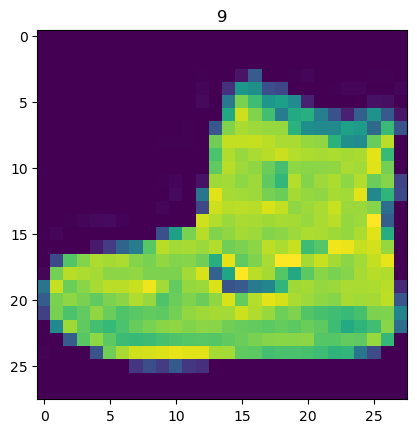

In [5]:
image, label = train[0]
plt.imshow(image.squeeze())
plt.title(label)

## Validate Dropout Using Different Models

In [6]:
# create fast dataloaders (avoid using if not enough vram)
train_loader = FastTensorDataLoader(train, shuffle=True)
test_loader = FastTensorDataLoader(test, shuffle=False)

In [7]:
from nn_models.simple import SimpleDropoutNetwork, SimpleDropoutNetworkSingle
from nn_models.lenet import DropoutLeNet
from nn_models.vgg import DropoutVGG
from utils.validate import train_and_validate

device = 'cuda' if torch.cuda.is_available() else 'cpu'

dropout_models = [
    SimpleDropoutNetwork,
    DropoutLeNet,
    DropoutVGG
]

dropout_rates = [0.0, 0.2, 0.4, 0.6, 0.8]

results = {}
saved_models = {}

for dropout_model in dropout_models:
    for p in dropout_rates:
        print(f"\nTesting Dropout p={p}")
        model = dropout_model(dropout_rate=p, dropout_mode="standard", input_channels=1, img_size=28).to(device)
        history = train_and_validate(model, train_loader, test_loader, epochs=60, max_norm=3.0) #TODO: testar outros valores max_norm? (ex: None, 4.0)
        try:
            results[model.name][p] = history
            saved_models[model.name][p] = model
        except:
            results[model.name] = {}
            results[model.name][p] = history
            saved_models[model.name] = {}
            saved_models[model.name][p] = model
        


Testing Dropout p=0.0


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 25.17it/s]


Finished in 2.39s

Testing Dropout p=0.2


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 22.39it/s]


Finished in 2.68s

Testing Dropout p=0.4


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 21.87it/s]


Finished in 2.74s

Testing Dropout p=0.6


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 23.83it/s]


Finished in 2.52s

Testing Dropout p=0.8


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 23.68it/s]


Finished in 2.53s

Testing Dropout p=0.0


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:08<00:00,  7.23it/s]


Finished in 8.30s

Testing Dropout p=0.2


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:08<00:00,  7.03it/s]


Finished in 8.53s

Testing Dropout p=0.4


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:08<00:00,  7.00it/s]


Finished in 8.57s

Testing Dropout p=0.6


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:08<00:00,  7.05it/s]


Finished in 8.51s

Testing Dropout p=0.8


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:08<00:00,  7.02it/s]


Finished in 8.54s

Testing Dropout p=0.0


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [04:14<00:00,  4.25s/it]


Finished in 254.92s

Testing Dropout p=0.2


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [04:21<00:00,  4.36s/it]


Finished in 261.63s

Testing Dropout p=0.4


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [04:06<00:00,  4.10s/it]


Finished in 246.23s

Testing Dropout p=0.6


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [04:06<00:00,  4.10s/it]


Finished in 246.24s

Testing Dropout p=0.8


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [04:18<00:00,  4.30s/it]

Finished in 258.29s


In [8]:
summarize_metrics(results)

Model  Dropout Rate  Test Acc (%)  F1 Score  \
5    LeNet Dropout Neural Network        0.0000       89.9100    0.8975   
6    LeNet Dropout Neural Network        0.2000       90.5300    0.9047   
7    LeNet Dropout Neural Network        0.4000       89.6700    0.8962   
8    LeNet Dropout Neural Network        0.6000       87.5700    0.8739   
9    LeNet Dropout Neural Network        0.8000       80.0300    0.7739   
0   Simple Dropout Neural Network        0.0000       89.2800    0.8934   
1   Simple Dropout Neural Network        0.2000       89.5600    0.8946   
2   Simple Dropout Neural Network        0.4000       89.6200    0.8958   
3   Simple Dropout Neural Network        0.6000       89.3100    0.8923   
4   Simple Dropout Neural Network        0.8000       87.4600    0.8740   
10     VGG Dropout Neural Network        0.0000       93.5700    0.9355   
11     VGG Dropout Neural Network        0.2000       93.2200    0.9318   
12     VGG Dropout Neural Network        0.4000       92.3800    0.9248   
13     VGG Dropout Neural Network        0.6000       92.7700    0.9263   
14     VGG Dropout Neural Network        0.8000       93.1300    0.9318   

    Test Loss  
5      0.2893  
6      0.2721  
7      0.2835  
8      0.3466  
9      0.5501  
0      0.4201  
1      0.3680  
2      0.3185  
3      0.3085  
4      0.3523  
10     0.5014  
11     0.3971  
12     0.4164  
13     0.4645  
14     0.3614

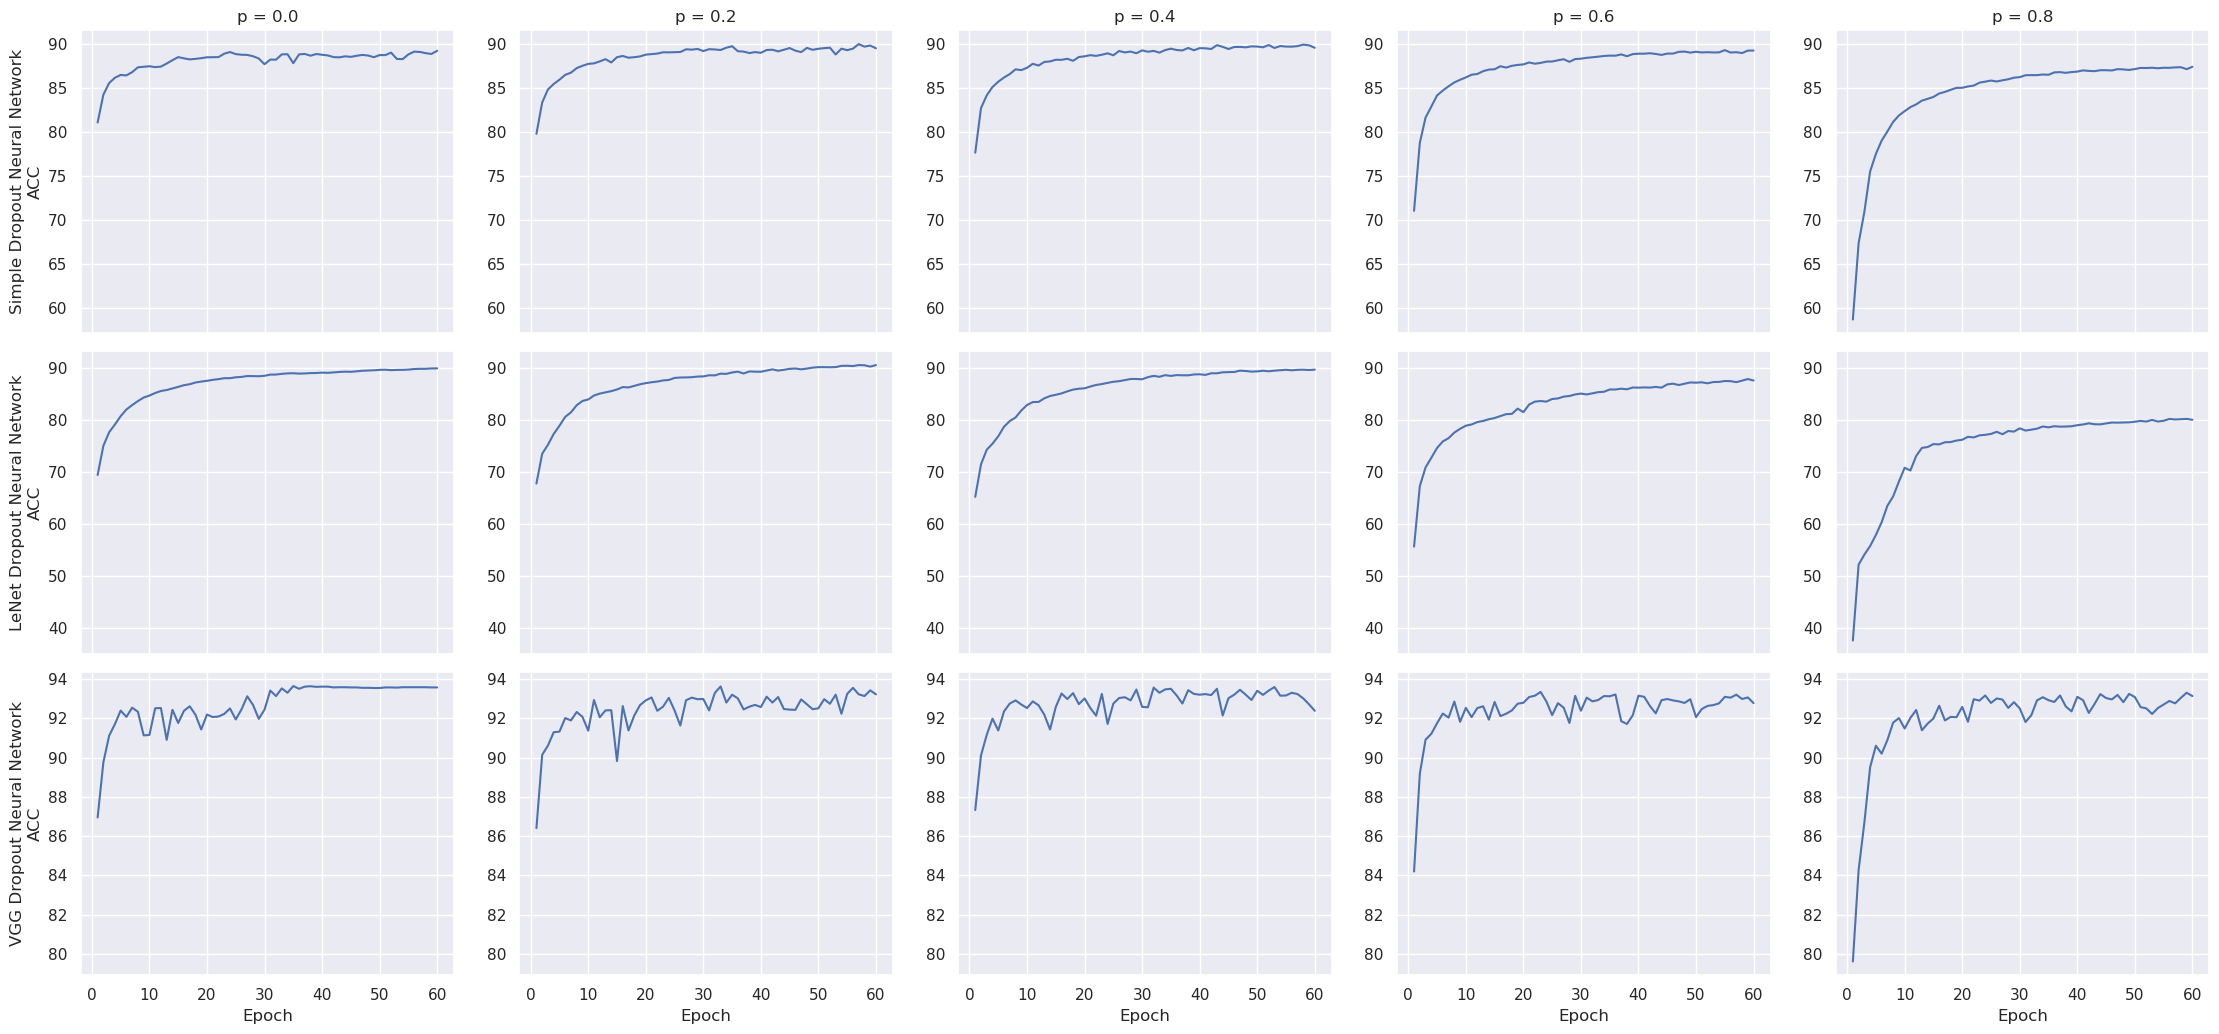

In [9]:
plot_dropout_histories(results, metric="acc")

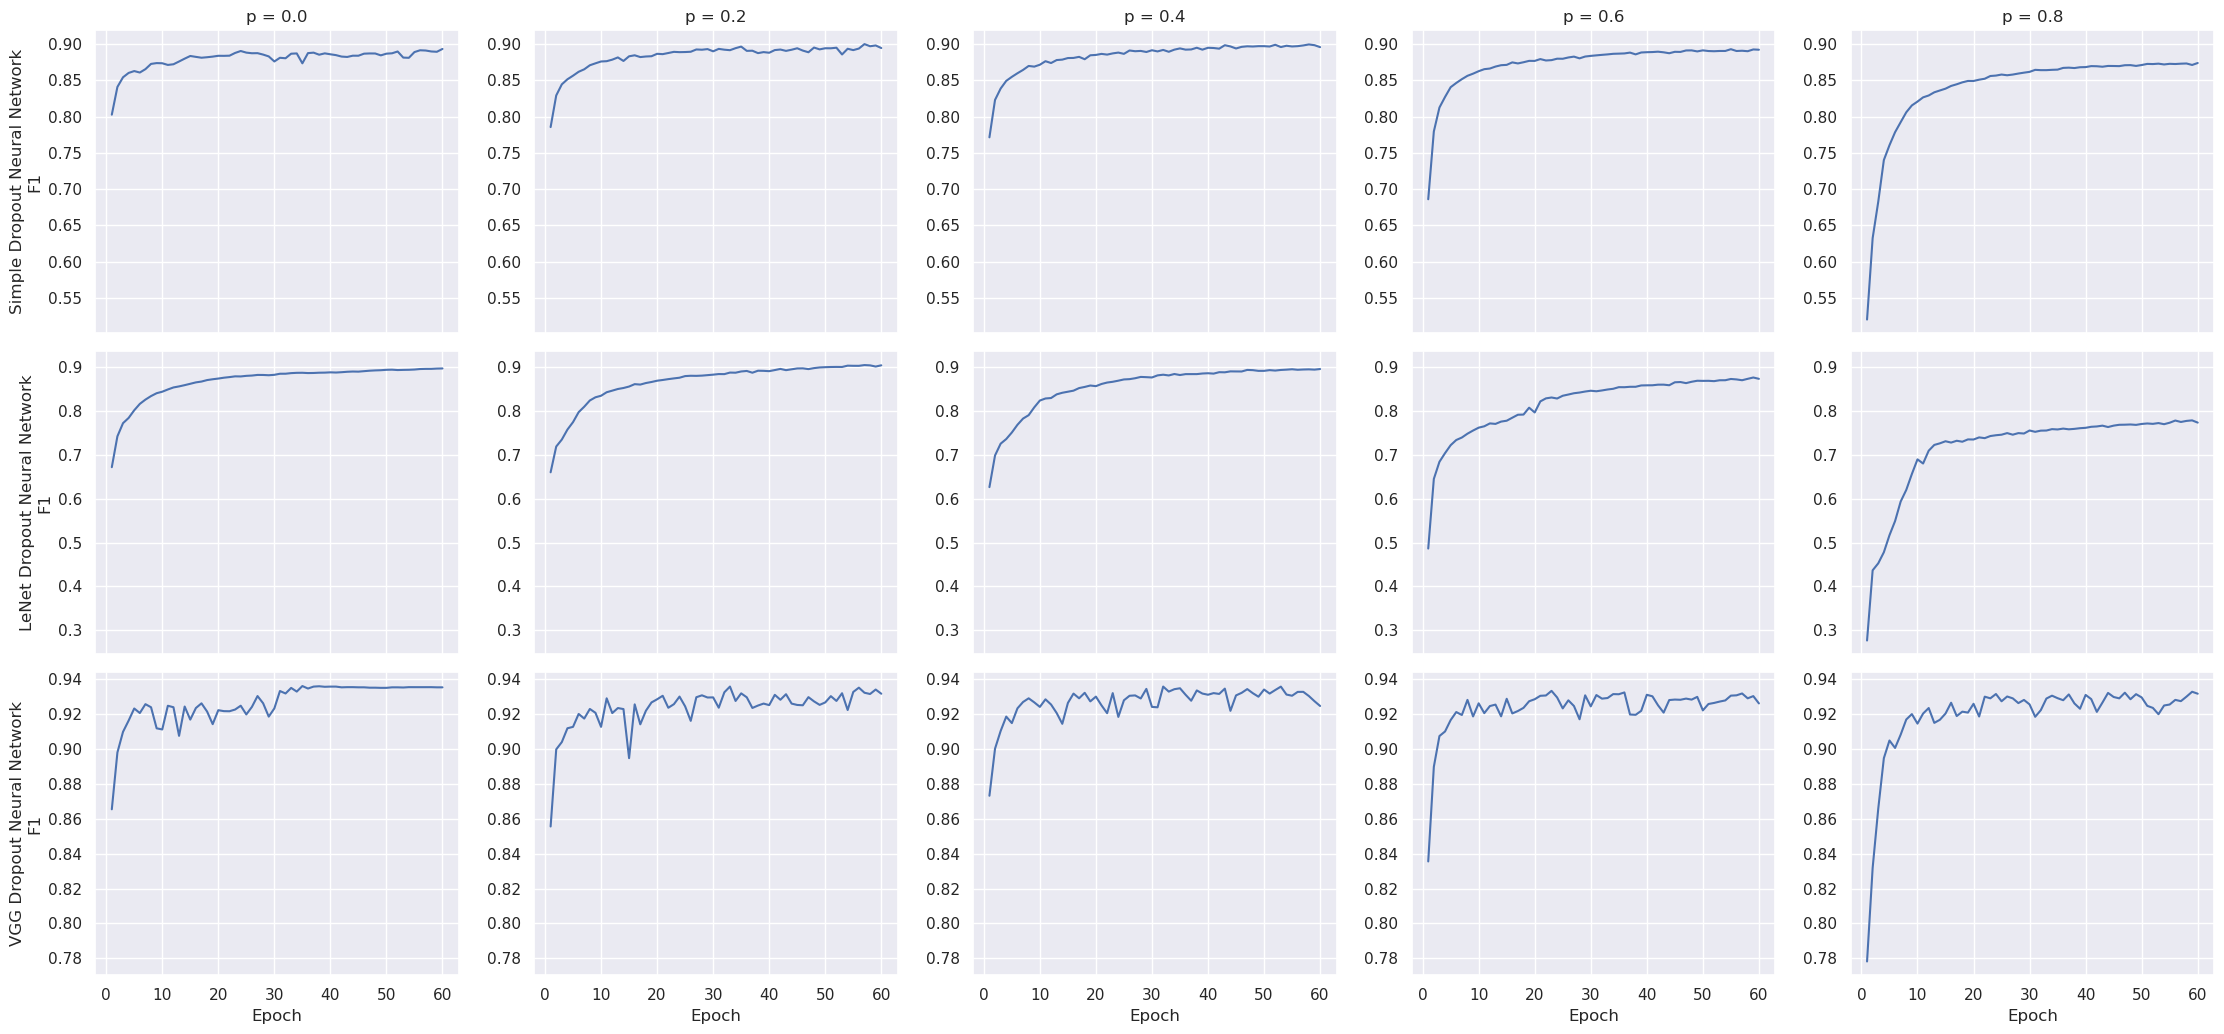

In [10]:
plot_dropout_histories(results, metric="f1")

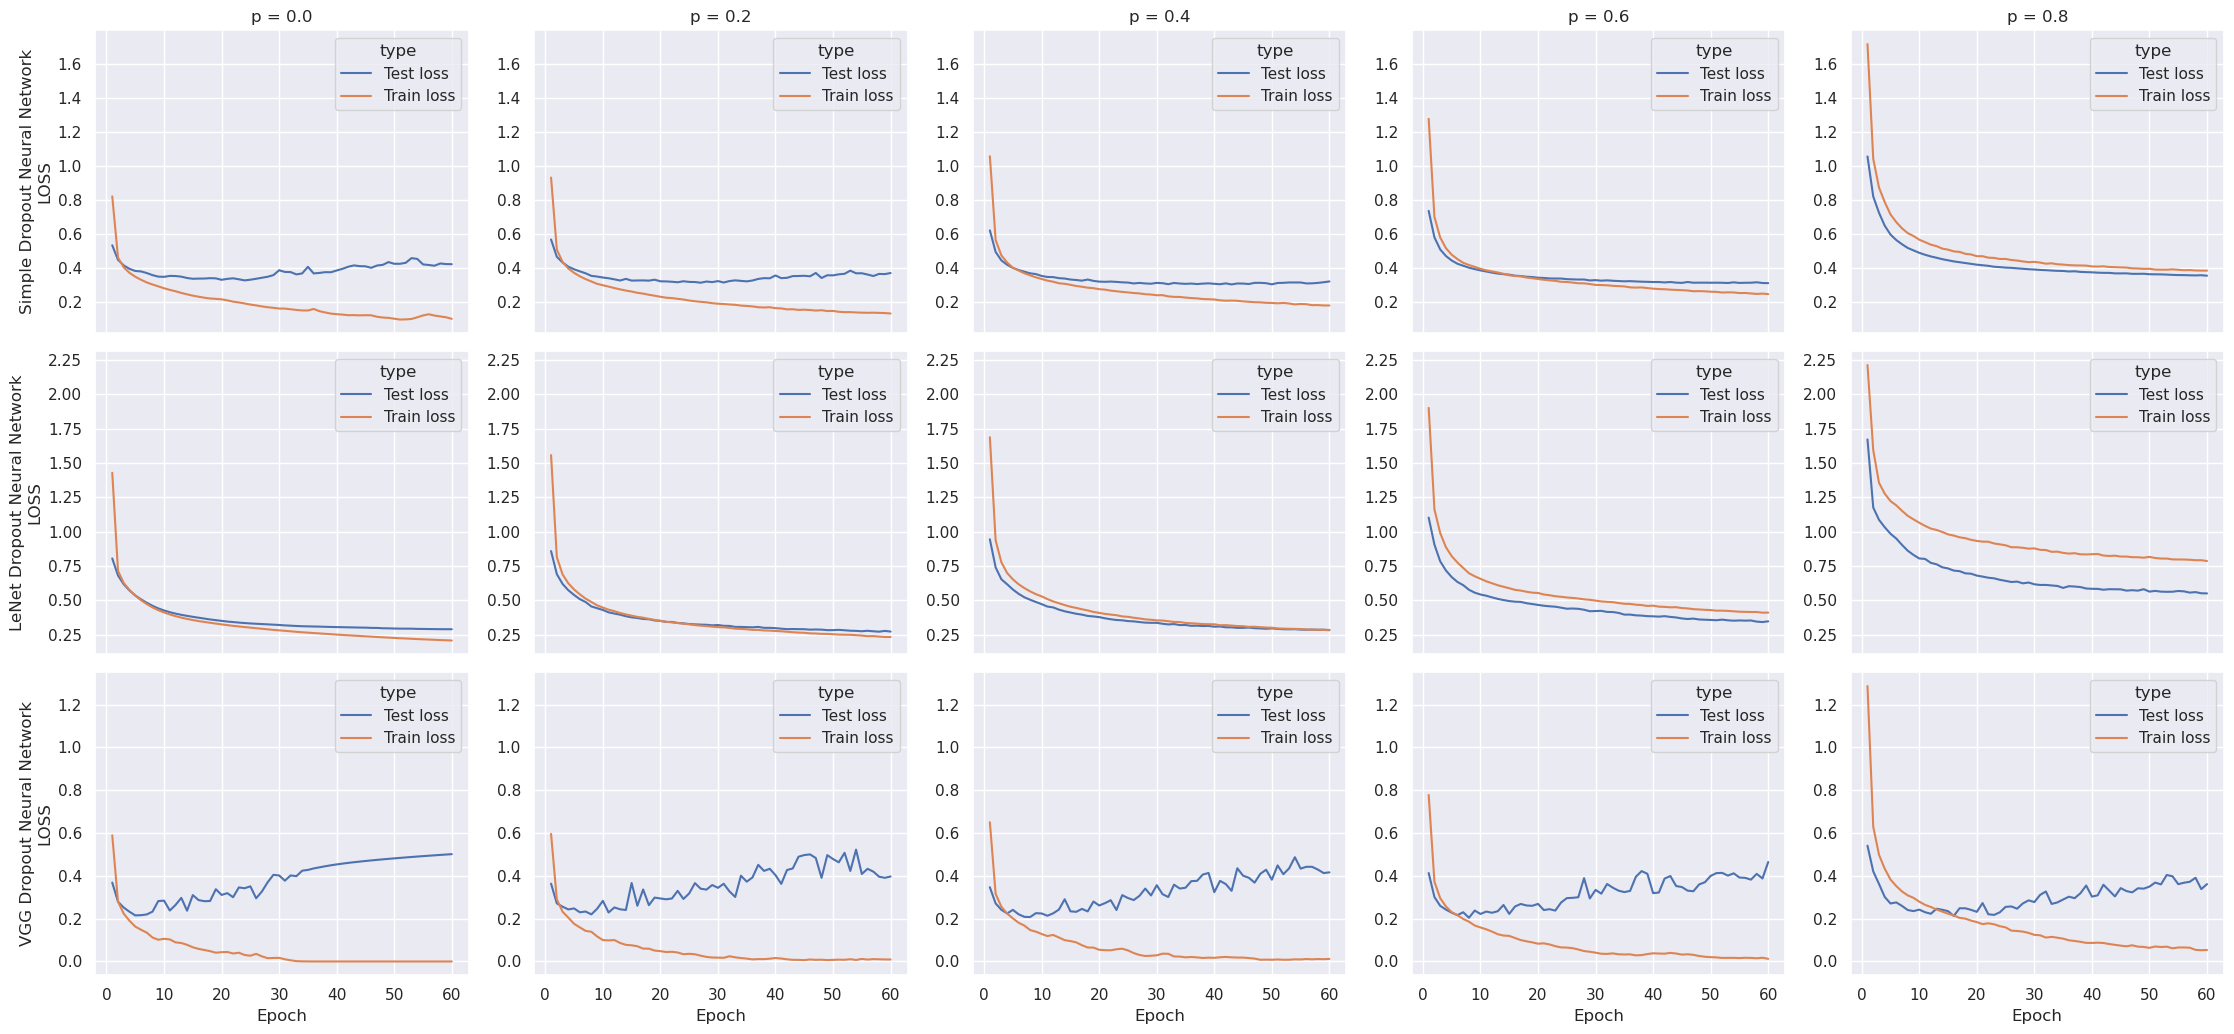

In [11]:
plot_dropout_histories(results, metric="loss")

## Verificando Correlação de Neurônios

/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_imp

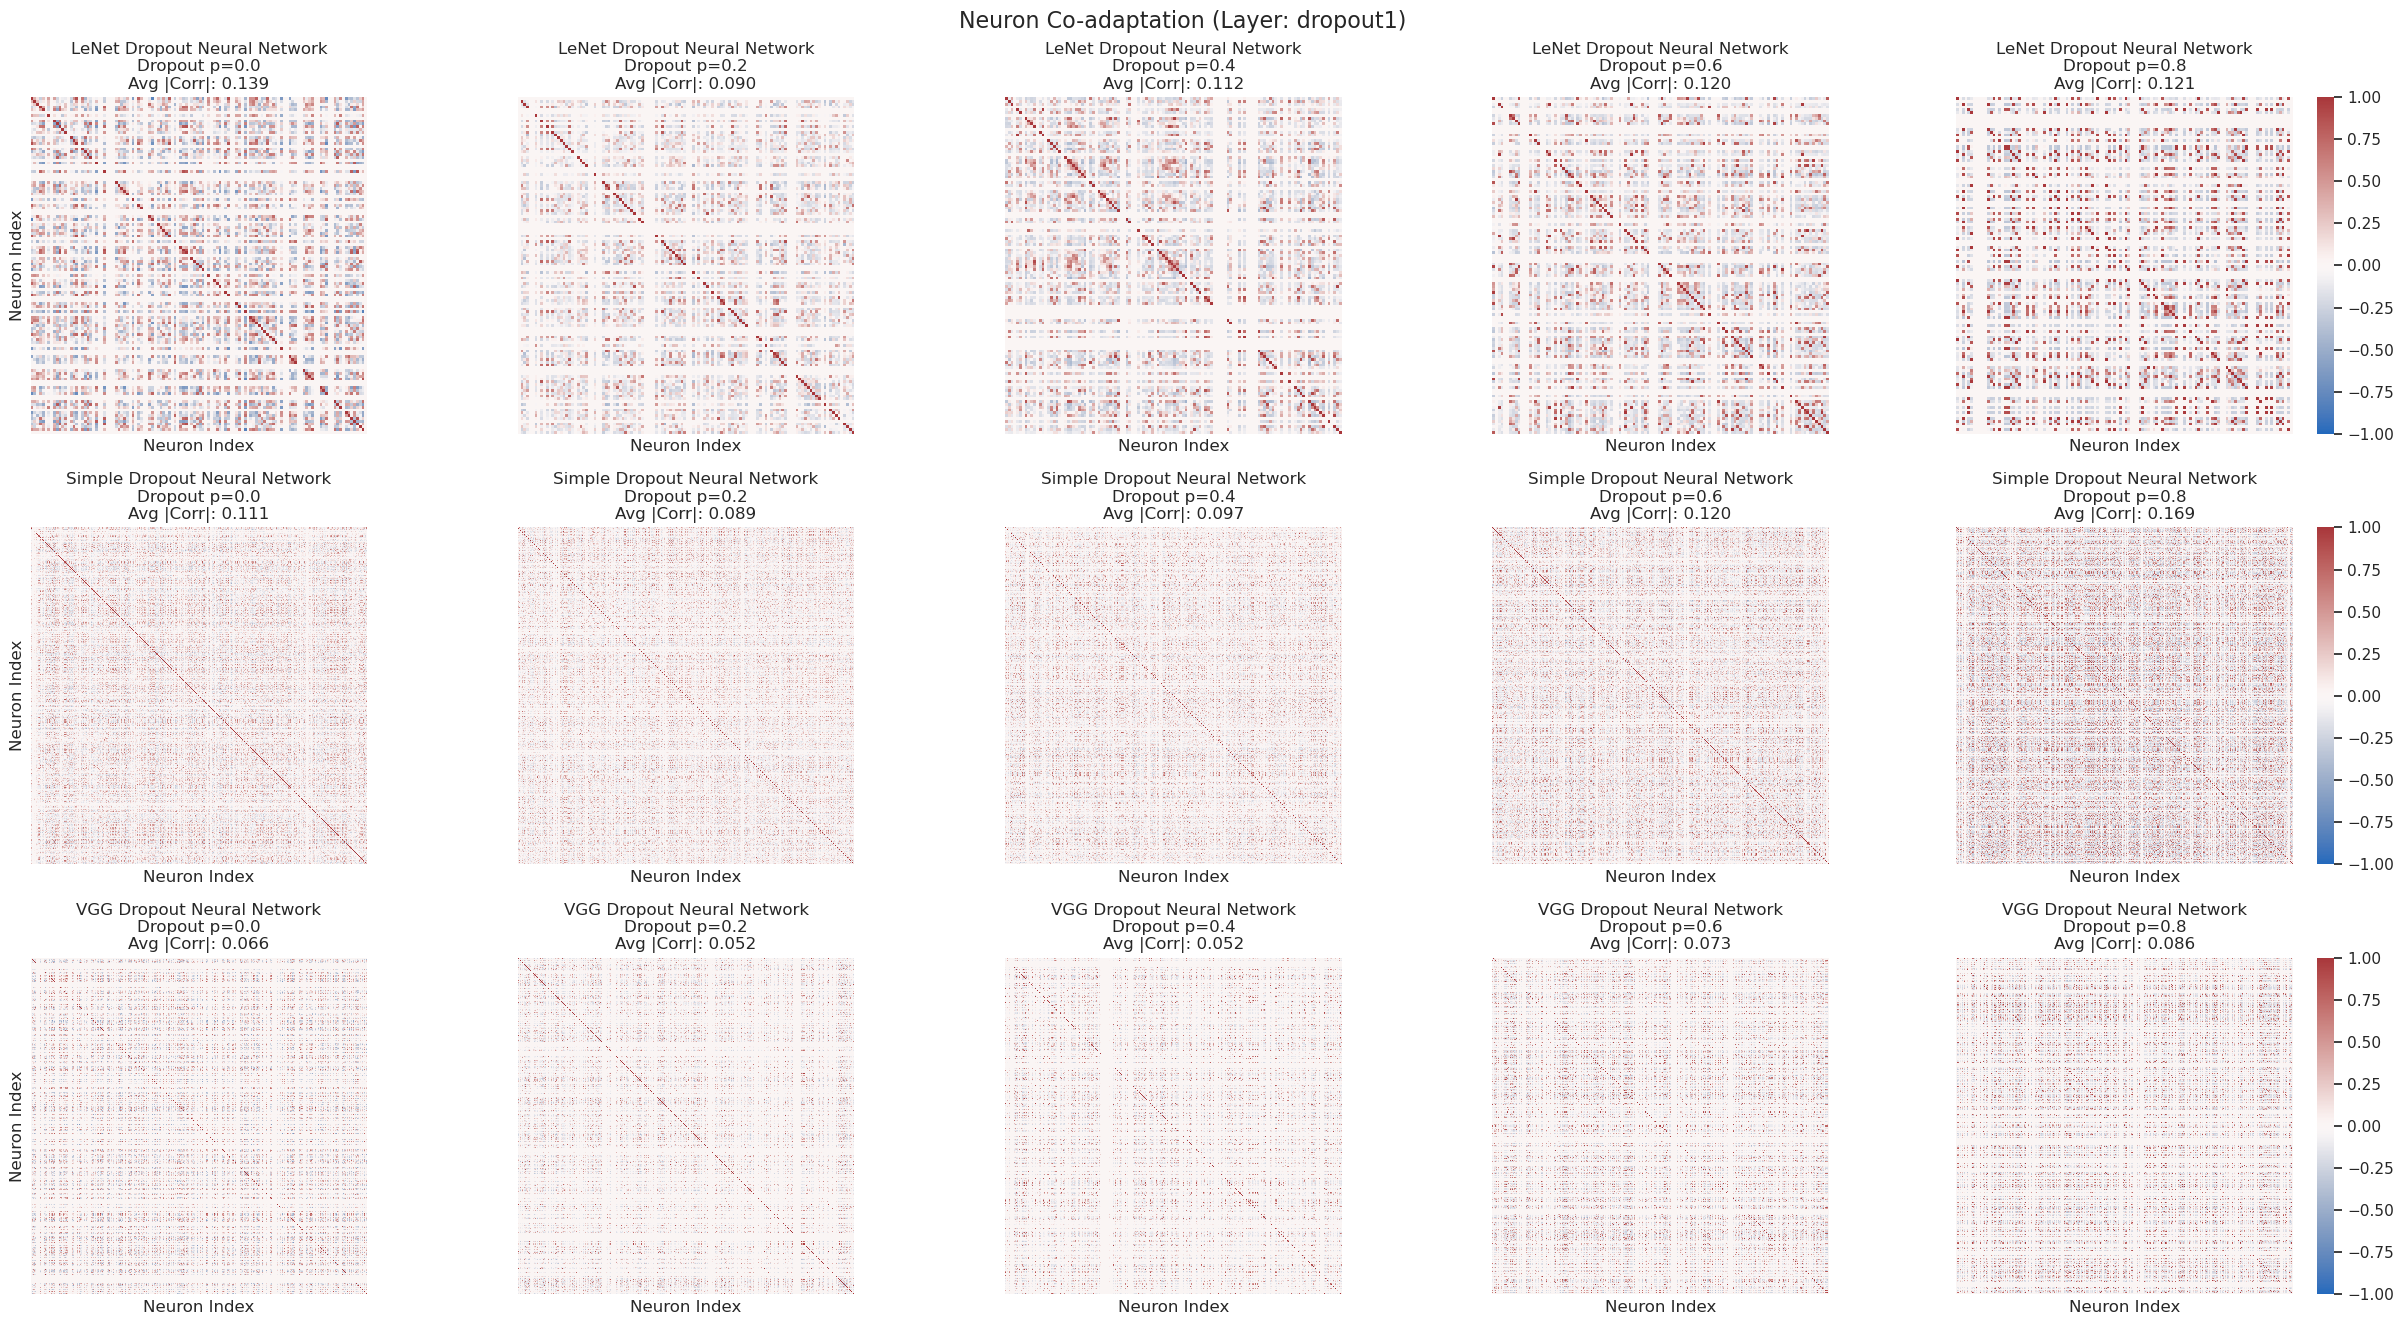

In [12]:
plot_neuron_correlations(saved_models, test_loader, layer_name='dropout1', device=device)

#### Pelas matrizes de correlação, vemos que dropout de 0.2 gerou resultados mais interessantes. É possível que dropout muito grande ative um "Modo Sobrevivência" das informações mais importantes garantindo que sejam repassadas por meio da maior redundância quando a dimensão de compressão é pequena demais para o problema

/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_imp

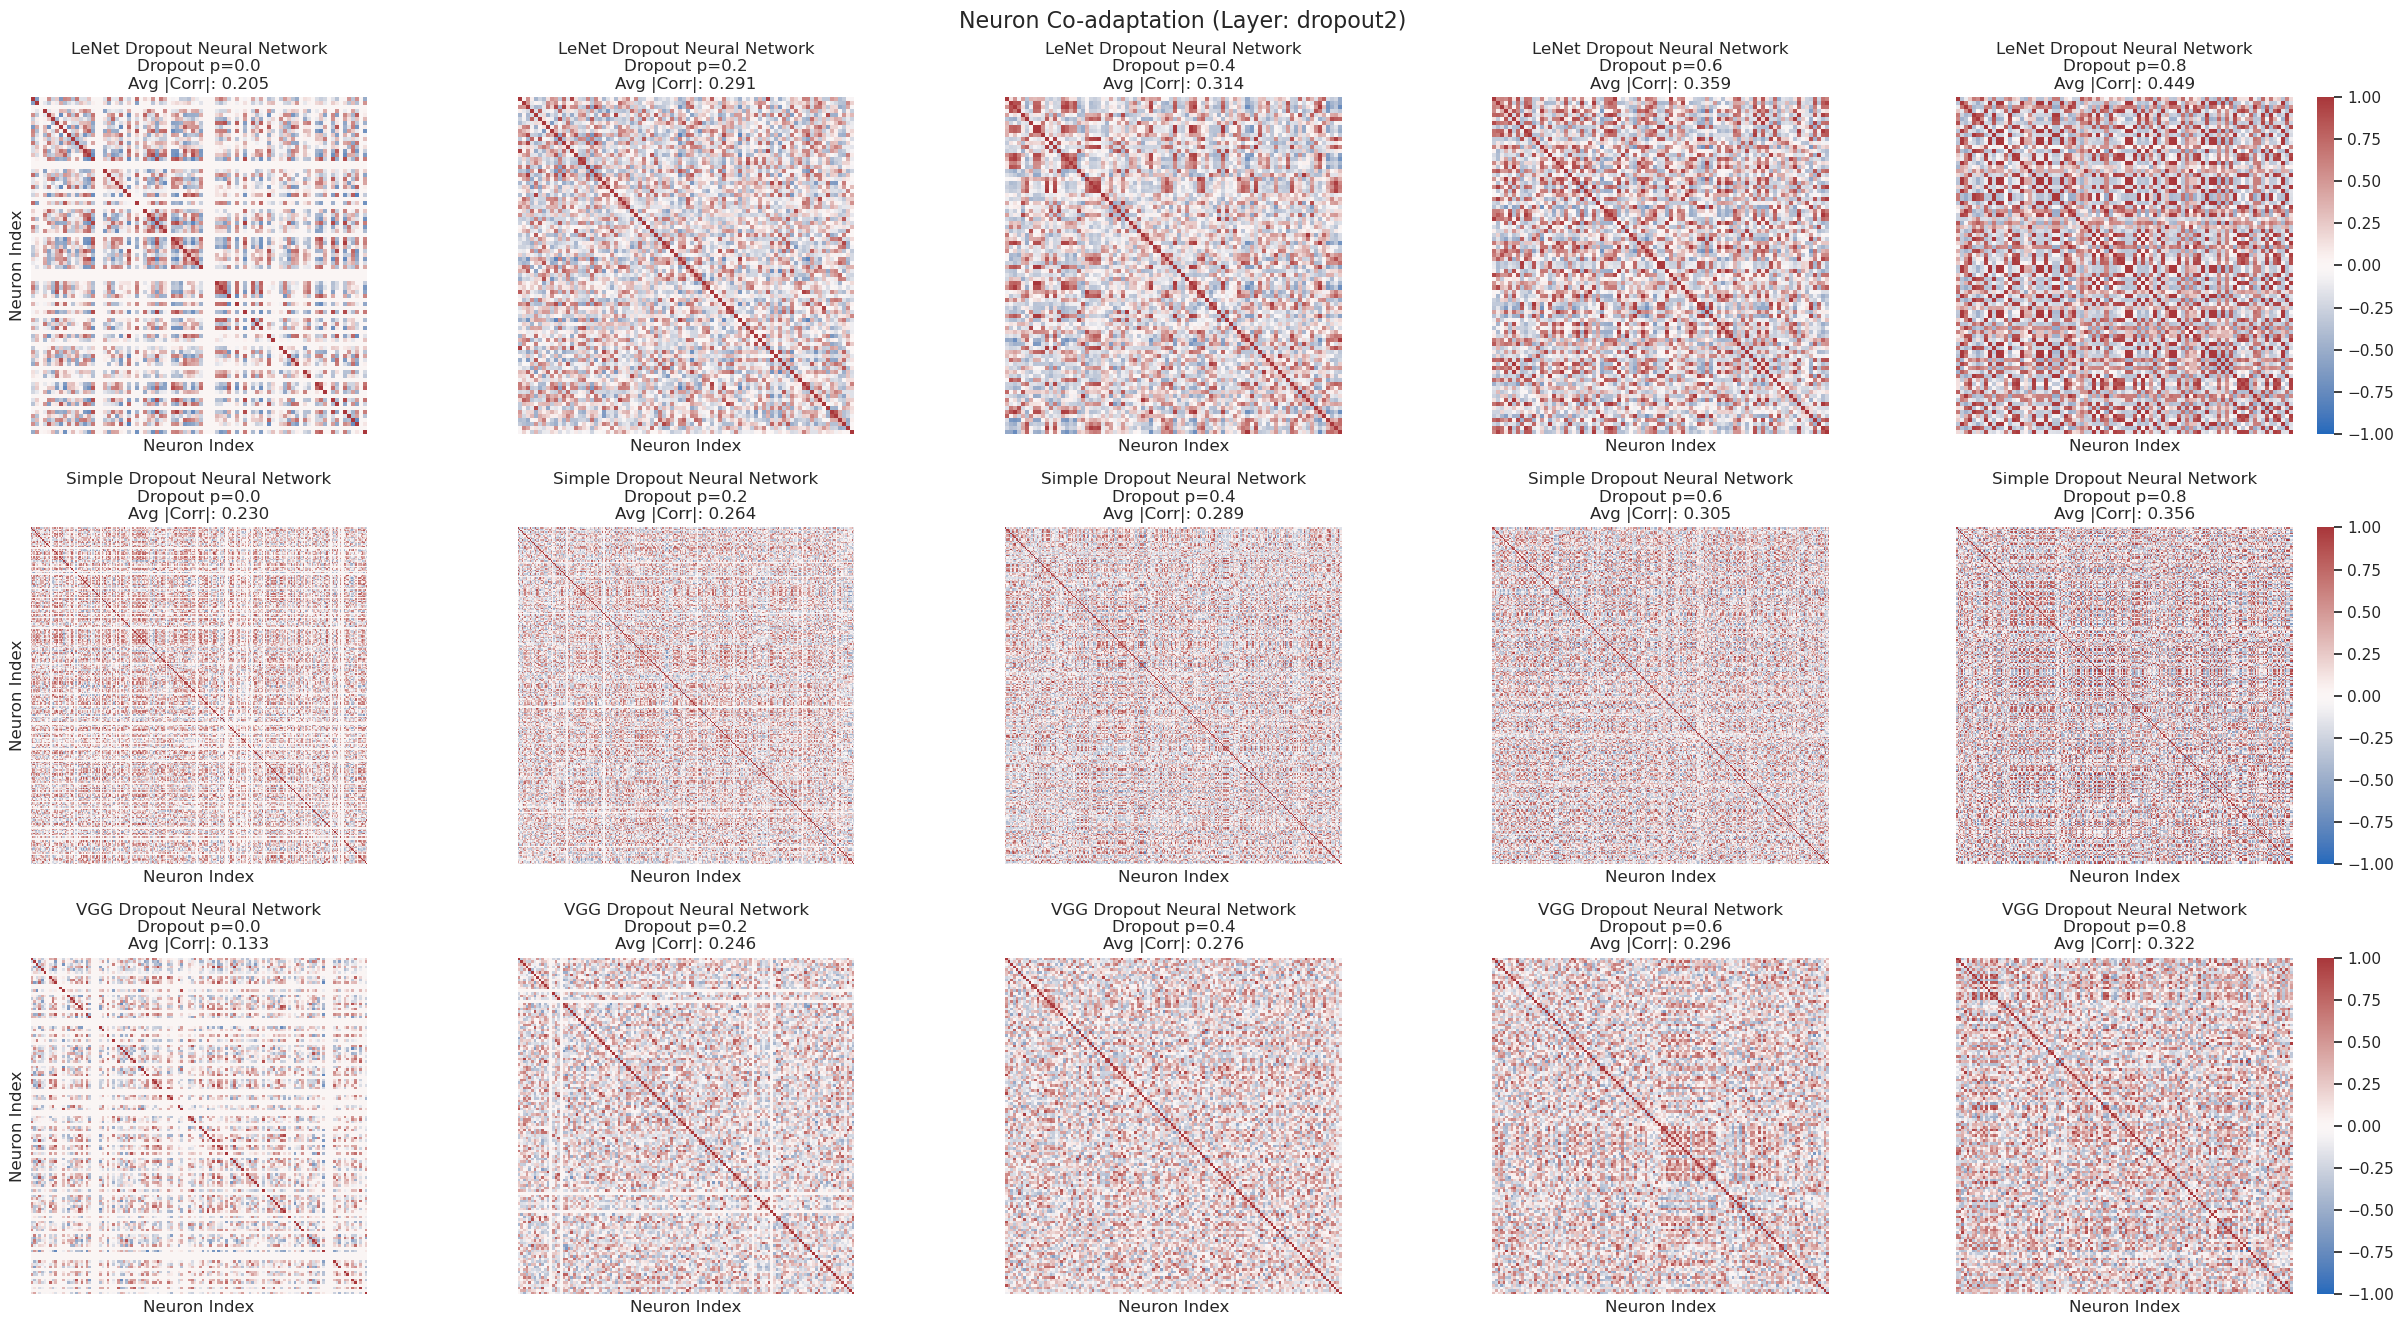

In [13]:
plot_neuron_correlations(saved_models, test_loader, layer_name='dropout2', device=device)

#### A segunda camada de dropout é mais profunda e nas redes escolhidas consiste em compressão dos dados. Pode ser que para o problema certas informações essenciais precisem ser passadas e a dimensão reduzida gere pressão para manter essas informações. Reduzir ainda mais os neurônios pode ativar o "Modo Sobrevivência" dessas informações que podem ser perdidas

In [14]:
correlation_results = {}
correlation_saved_models = {}
    
for p in dropout_rates:
    print(f"\nTesting Dropout p={p}")
    model = SimpleDropoutNetworkSingle(dropout_rate=p, dropout_mode="standard", input_channels=1, img_size=28).to(device)
    history = train_and_validate(model, train_loader, test_loader, epochs=60, max_norm=3.0)
    try:
        correlation_results[model.name][p] = history
        correlation_saved_models[model.name][p] = model
    except:
        correlation_results[model.name] = {}
        correlation_results[model.name][p] = history
        correlation_saved_models[model.name] = {}
        correlation_saved_models[model.name][p] = model
        


Testing Dropout p=0.0


Training model 'Single Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 25.33it/s]


Finished in 2.37s

Testing Dropout p=0.2


Training model 'Single Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 22.62it/s]


Finished in 2.65s

Testing Dropout p=0.4


Training model 'Single Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 22.64it/s]


Finished in 2.65s

Testing Dropout p=0.6


Training model 'Single Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 22.09it/s]


Finished in 2.72s

Testing Dropout p=0.8


Training model 'Single Dropout Neural Network': 100%|██████████| 60/60 [00:02<00:00, 22.16it/s]

Finished in 2.71s


In [15]:
summarize_metrics(correlation_results)

Model  Dropout Rate  Test Acc (%)  F1 Score  \
0  Single Dropout Neural Network        0.0000       88.8700    0.8867   
1  Single Dropout Neural Network        0.2000       89.7900    0.8969   
2  Single Dropout Neural Network        0.4000       89.8400    0.8971   
3  Single Dropout Neural Network        0.6000       89.7100    0.8963   
4  Single Dropout Neural Network        0.8000       88.7400    0.8868   

   Test Loss  
0     0.4746  
1     0.3737  
2     0.3298  
3     0.3055  
4     0.3168

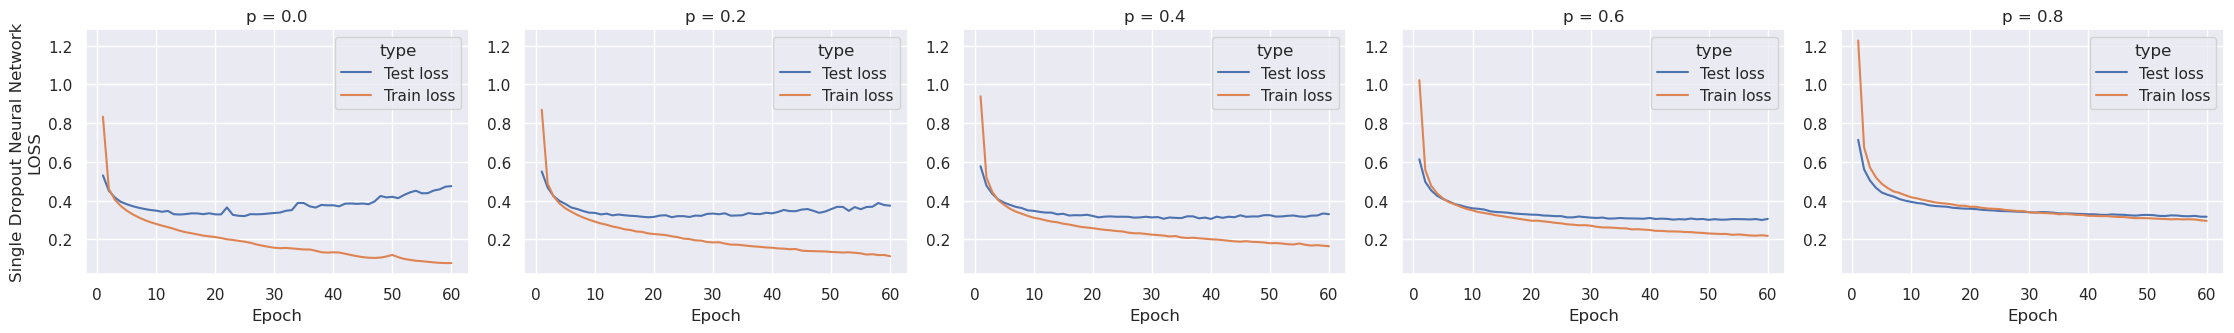

In [16]:
plot_dropout_histories(correlation_results, metric="loss")

/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paulofr/miniforge3/envs/DROPOUT/lib/python3.10/site-packages/numpy/lib/_function_base_imp

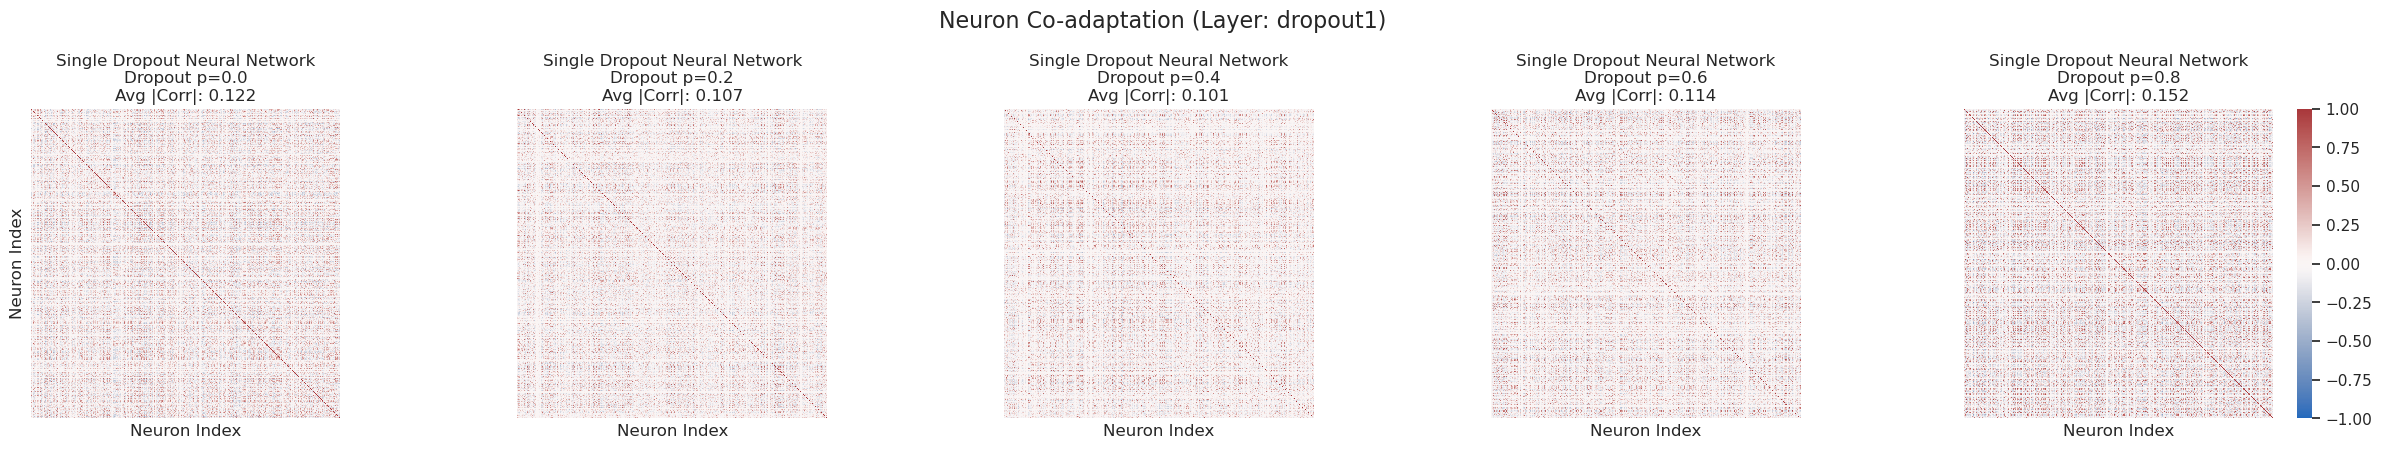

In [17]:
plot_neuron_correlations(correlation_saved_models, test_loader, layer_name='dropout1', device=device)

## Training with Subset

In [18]:
len(train)

60000

In [19]:
indices = np.random.choice(len(train), size=1000, replace=False)
train_subset = Subset(train, indices)

train_loader_small = FastTensorDataLoader(train_subset, shuffle=True, batch_size=4096)

In [20]:
results_small = {}

for dropout_model in dropout_models:
    for p in dropout_rates:
        print(f"\nTesting Dropout p={p}") 
        model = dropout_model(dropout_rate=p, dropout_mode="inverted", input_channels=1, img_size=28).to(device)
        history = train_and_validate(model, train_loader_small, test_loader, epochs=60, max_norm=3.0)
        try:
            results_small[model.name][p] = history
        except:
            results_small[model.name] = {}
            results_small[model.name][p] = history


Testing Dropout p=0.0


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:00<00:00, 183.78it/s]


Finished in 0.33s

Testing Dropout p=0.2


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:00<00:00, 167.11it/s]


Finished in 0.36s

Testing Dropout p=0.4


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:00<00:00, 182.52it/s]


Finished in 0.33s

Testing Dropout p=0.6


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:00<00:00, 176.89it/s]


Finished in 0.34s

Testing Dropout p=0.8


Training model 'Simple Dropout Neural Network': 100%|██████████| 60/60 [00:00<00:00, 175.46it/s]


Finished in 0.34s

Testing Dropout p=0.0


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:00<00:00, 79.70it/s]


Finished in 0.75s

Testing Dropout p=0.2


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:00<00:00, 77.86it/s]


Finished in 0.77s

Testing Dropout p=0.4


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:00<00:00, 77.87it/s]


Finished in 0.77s

Testing Dropout p=0.6


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:00<00:00, 78.41it/s]


Finished in 0.77s

Testing Dropout p=0.8


Training model 'LeNet Dropout Neural Network': 100%|██████████| 60/60 [00:00<00:00, 78.52it/s]


Finished in 0.77s

Testing Dropout p=0.0


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [00:16<00:00,  3.61it/s]


Finished in 16.62s

Testing Dropout p=0.2


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [00:16<00:00,  3.73it/s]


Finished in 16.07s

Testing Dropout p=0.4


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [00:15<00:00,  3.82it/s]


Finished in 15.69s

Testing Dropout p=0.6


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [00:15<00:00,  3.76it/s]


Finished in 15.97s

Testing Dropout p=0.8


Training model 'VGG Dropout Neural Network': 100%|██████████| 60/60 [00:16<00:00,  3.69it/s]

Finished in 16.27s


In [21]:
summarize_metrics(results_small)

Model  Dropout Rate  Test Acc (%)  F1 Score  \
5    LeNet Dropout Neural Network        0.0000       71.9100    0.7105   
6    LeNet Dropout Neural Network        0.2000       71.8400    0.7071   
7    LeNet Dropout Neural Network        0.4000       67.6000    0.6529   
8    LeNet Dropout Neural Network        0.6000       69.5700    0.6730   
9    LeNet Dropout Neural Network        0.8000       59.1600    0.5565   
0   Simple Dropout Neural Network        0.0000       80.6000    0.8066   
1   Simple Dropout Neural Network        0.2000       80.7800    0.8072   
2   Simple Dropout Neural Network        0.4000       80.9000    0.8084   
3   Simple Dropout Neural Network        0.6000       79.4800    0.7921   
4   Simple Dropout Neural Network        0.8000       73.6100    0.7227   
10     VGG Dropout Neural Network        0.0000       84.0500    0.8382   
11     VGG Dropout Neural Network        0.2000       83.2600    0.8303   
12     VGG Dropout Neural Network        0.4000       83.3300    0.8277   
13     VGG Dropout Neural Network        0.6000       83.2100    0.8295   
14     VGG Dropout Neural Network        0.8000       78.6500    0.7579   

    Test Loss  
5      0.7985  
6      0.7491  
7      0.8586  
8      0.8477  
9      1.2562  
0      0.6486  
1      0.6065  
2      0.5810  
3      0.6050  
4      0.7012  
10     0.5783  
11     0.6373  
12     0.6901  
13     0.6511  
14     0.6132

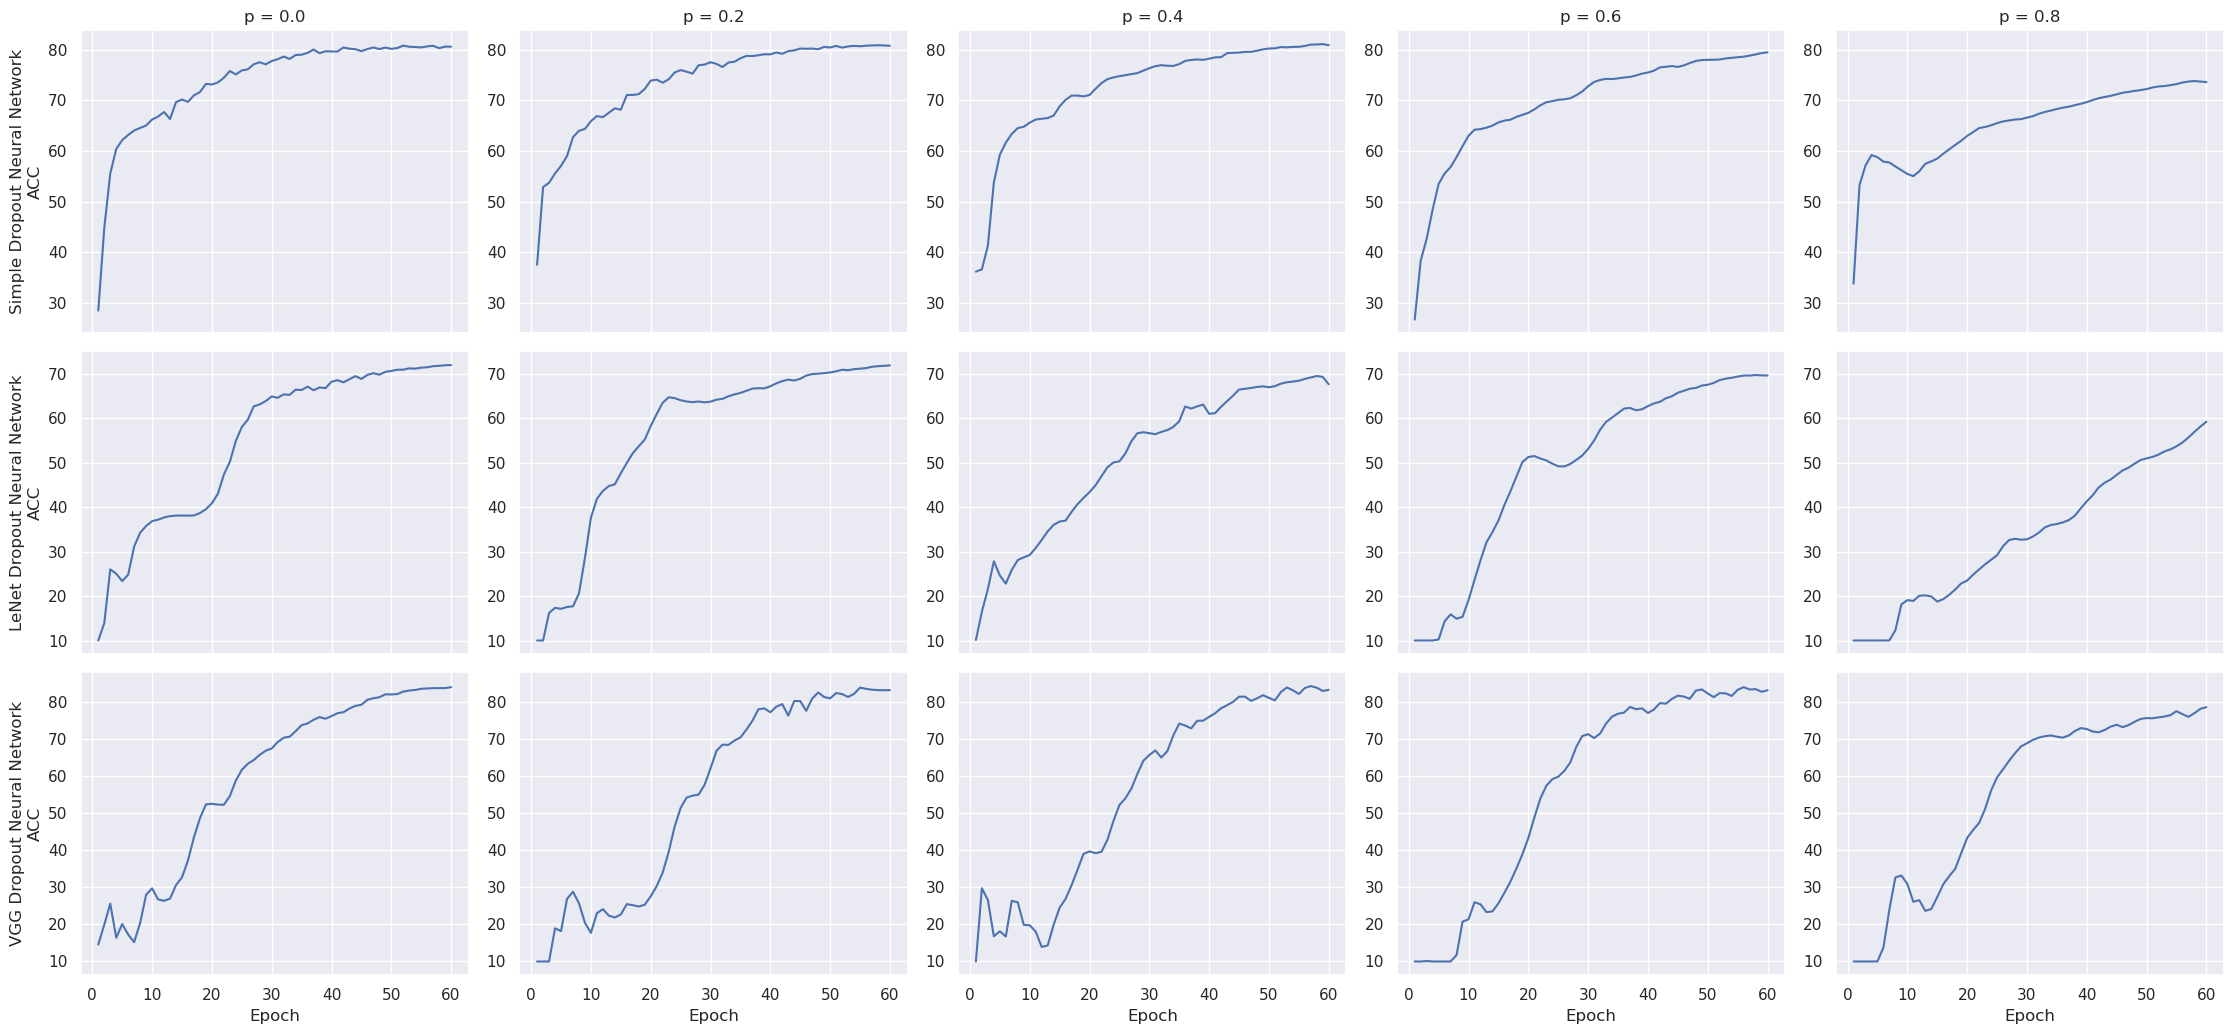

In [22]:
plot_dropout_histories(results_small, metric="acc")

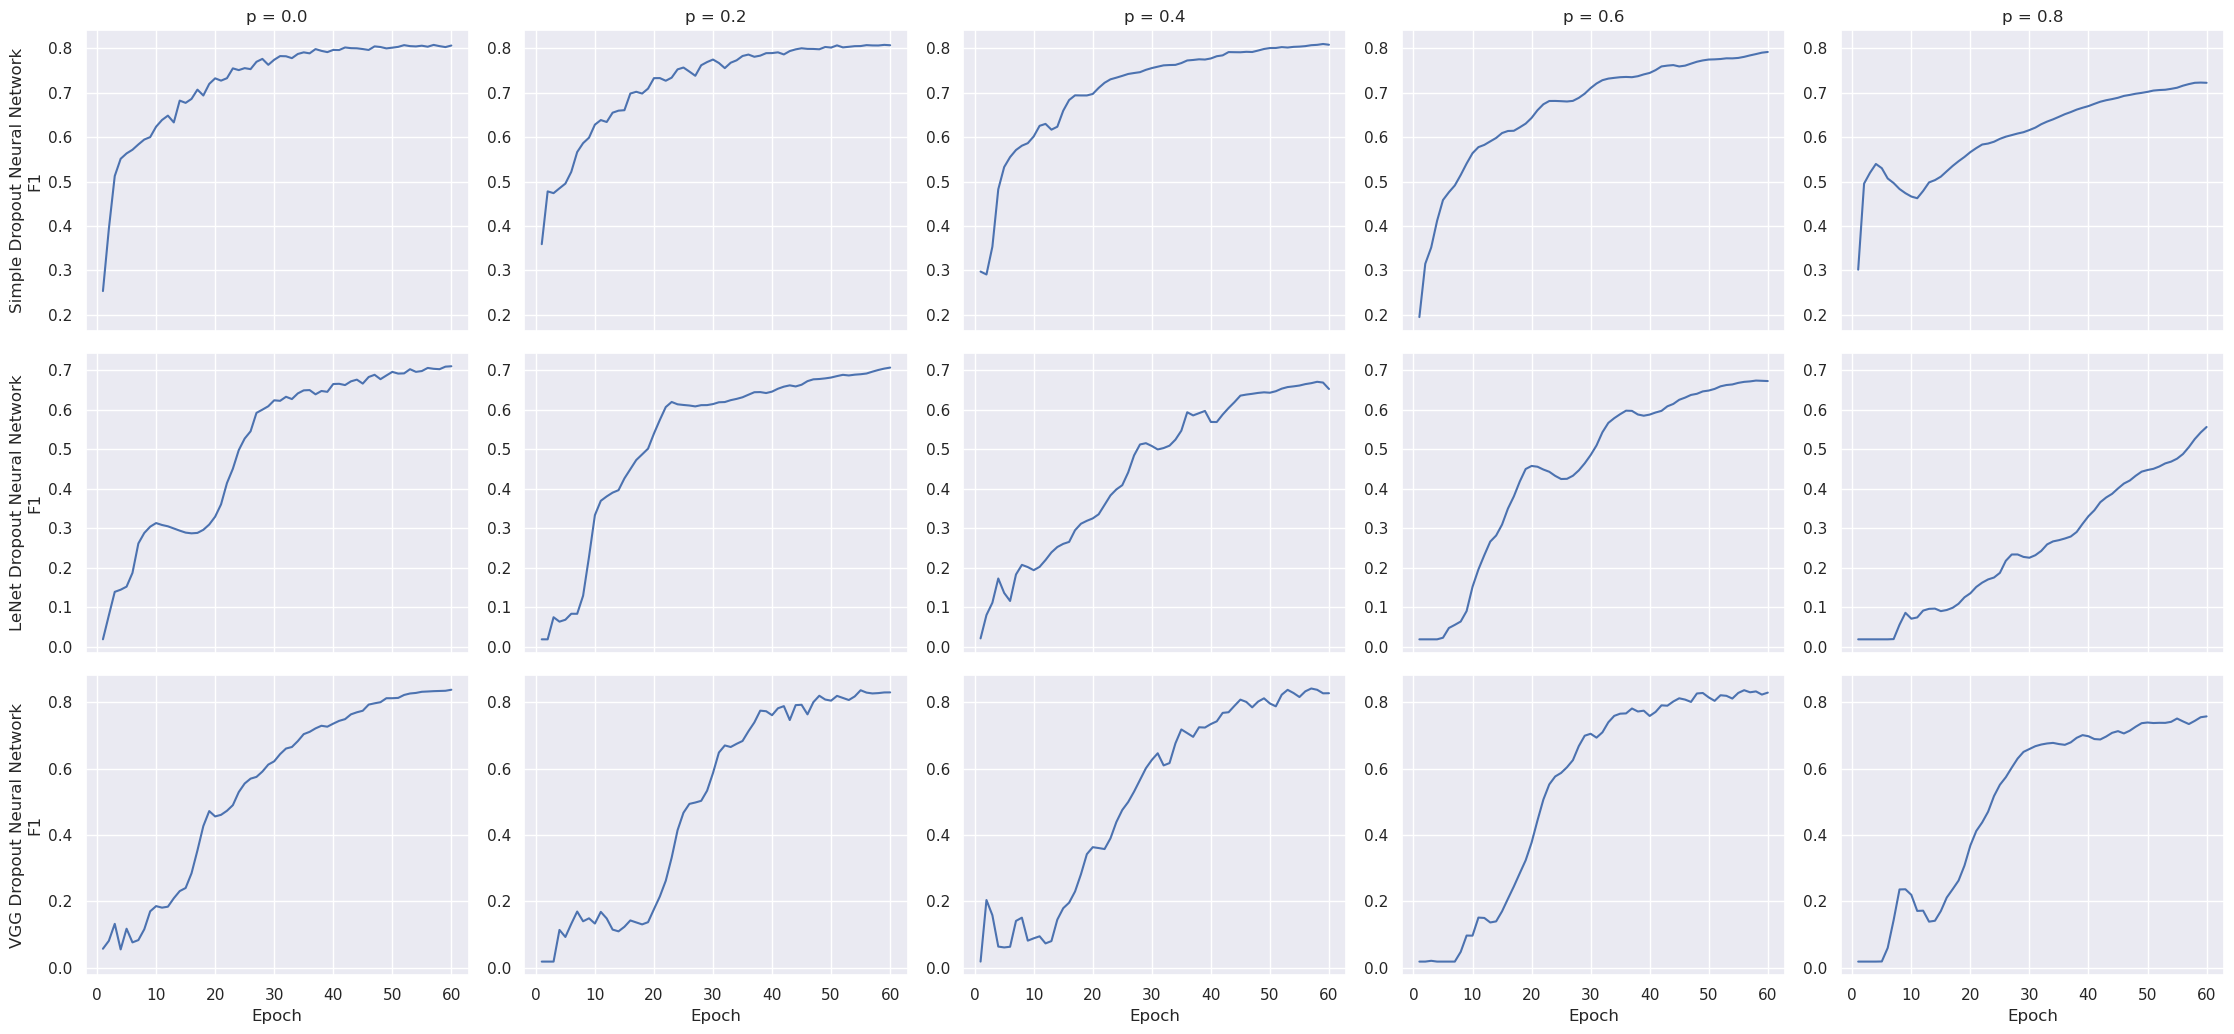

In [23]:
plot_dropout_histories(results_small, metric="f1")

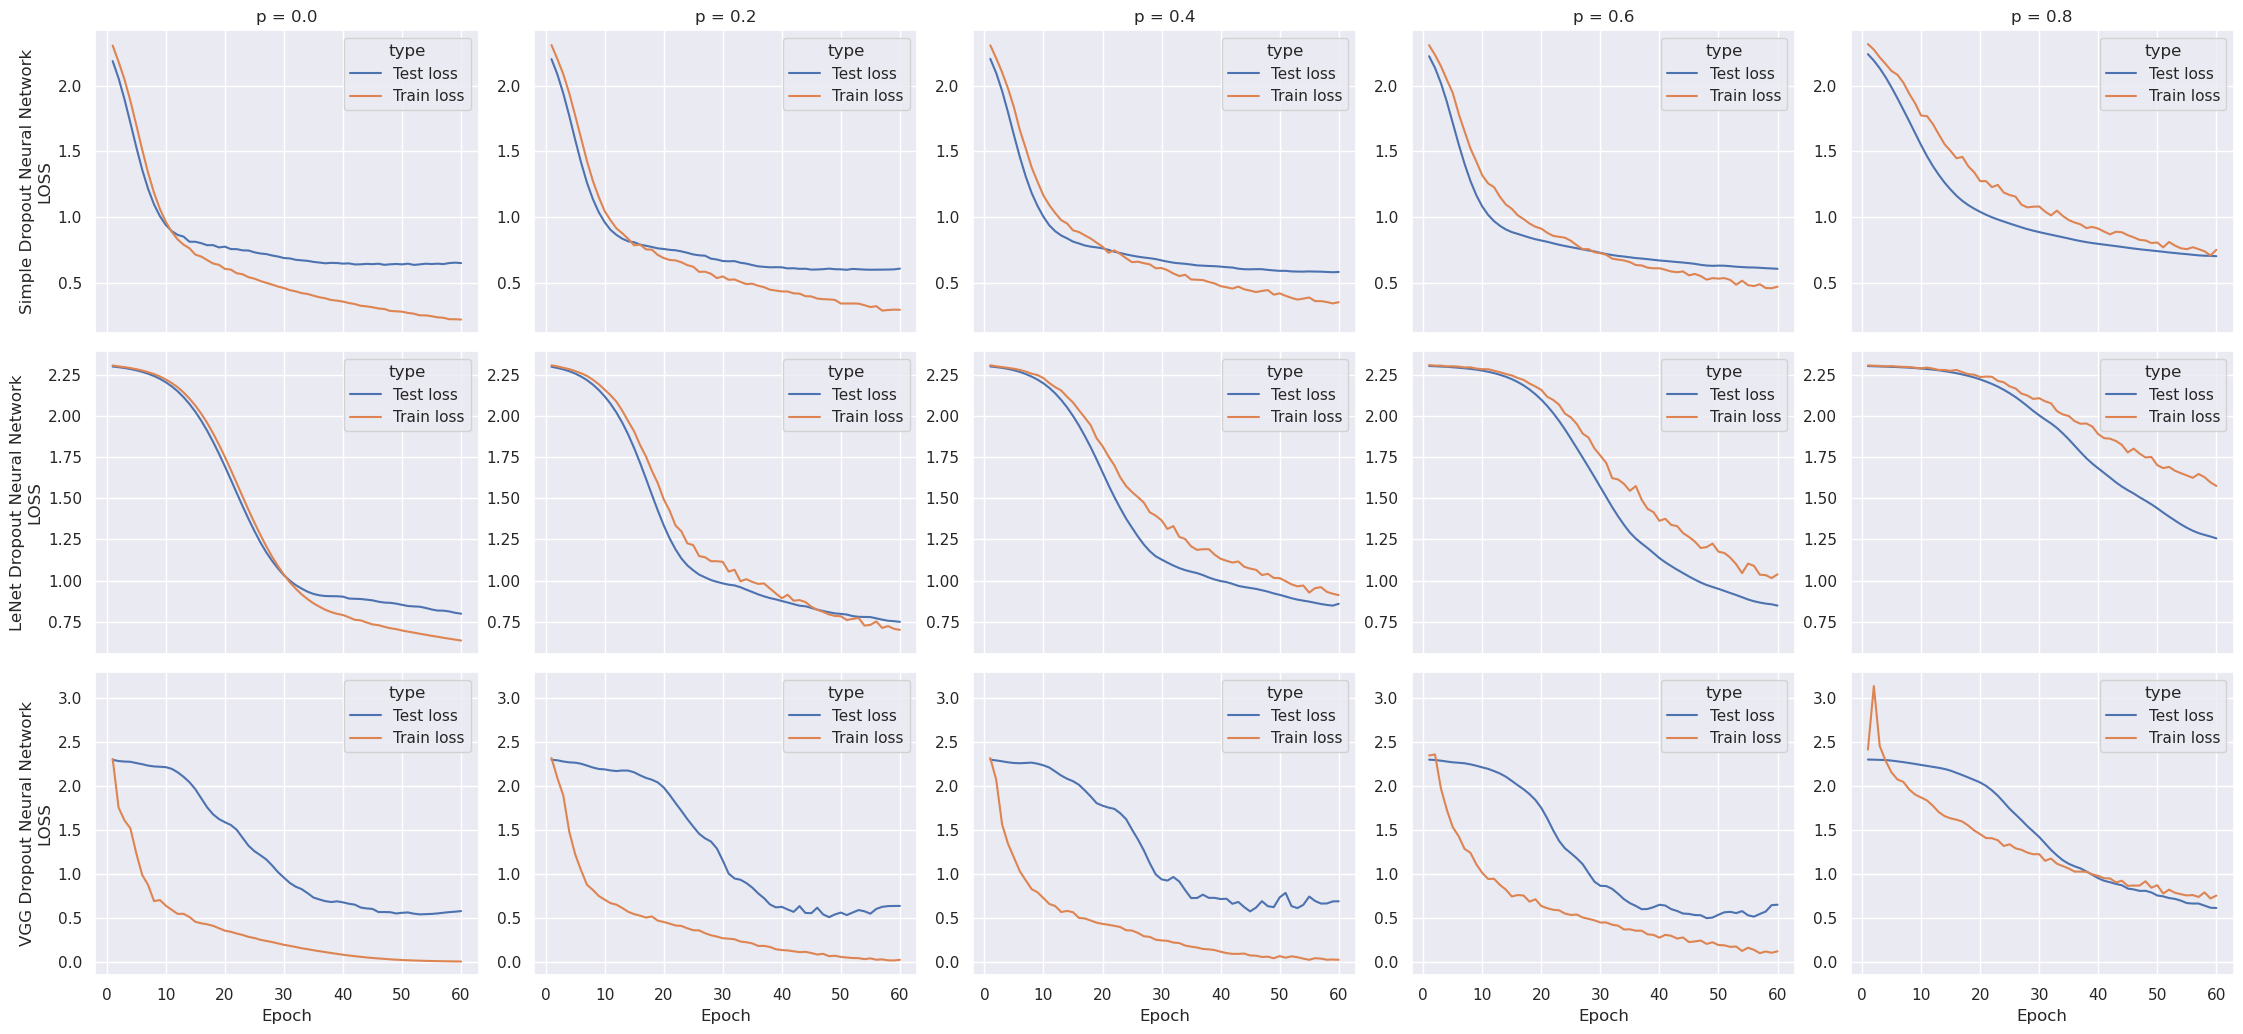

In [24]:
plot_dropout_histories(results_small, metric="loss")

## Training with Noise

In [25]:
len(train)

60000

In [26]:
# create noise
noise_level = 0.1
num_corrupted = int(len(train) * noise_level)

corrupt_indices = torch.randperm(len(train))[:num_corrupted]
train_loader.targets[corrupt_indices] = torch.randint(
    0, 10, (num_corrupted,), device=device
)

In [27]:
results = {}

for dropout_model in dropout_models:
    for p in dropout_rates:
        print(f"\nTesting Dropout p={p}")
        model = dropout_model(dropout_rate=p, dropout_mode="inverted", input_channels=1, img_size=28).to(device)
        history = train_and_validate(model, train_loader, test_loader, epochs=100, max_norm=3.0) #TODO: testar outros valores max_norm? (ex: None, 4.0)
        try:
            results[model.name][p] = history
        except:
            results[model.name] = {}
            results[model.name][p] = history


Testing Dropout p=0.0


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:03<00:00, 25.10it/s]


Finished in 3.98s

Testing Dropout p=0.2


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:04<00:00, 20.76it/s]


Finished in 4.82s

Testing Dropout p=0.4


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:04<00:00, 20.84it/s]


Finished in 4.80s

Testing Dropout p=0.6


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:04<00:00, 20.74it/s]


Finished in 4.82s

Testing Dropout p=0.8


Training model 'Simple Dropout Neural Network': 100%|██████████| 100/100 [00:04<00:00, 20.51it/s]


Finished in 4.88s

Testing Dropout p=0.0


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Finished in 14.75s

Testing Dropout p=0.2


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:15<00:00,  6.46it/s]


Finished in 15.48s

Testing Dropout p=0.4


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


Finished in 15.50s

Testing Dropout p=0.6


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:15<00:00,  6.41it/s]


Finished in 15.60s

Testing Dropout p=0.8


Training model 'LeNet Dropout Neural Network': 100%|██████████| 100/100 [00:15<00:00,  6.43it/s]


Finished in 15.56s

Testing Dropout p=0.0


Training model 'VGG Dropout Neural Network': 100%|██████████| 100/100 [07:13<00:00,  4.33s/it]


Finished in 433.21s

Testing Dropout p=0.2


Training model 'VGG Dropout Neural Network': 100%|██████████| 100/100 [07:16<00:00,  4.37s/it]


Finished in 436.67s

Testing Dropout p=0.4


Training model 'VGG Dropout Neural Network': 100%|██████████| 100/100 [07:14<00:00,  4.34s/it]


Finished in 434.40s

Testing Dropout p=0.6


Training model 'VGG Dropout Neural Network': 100%|██████████| 100/100 [07:13<00:00,  4.34s/it]


Finished in 433.59s

Testing Dropout p=0.8


Training model 'VGG Dropout Neural Network': 100%|██████████| 100/100 [07:09<00:00,  4.30s/it]

Finished in 429.81s


In [28]:
summarize_metrics(results)

Model  Dropout Rate  Test Acc (%)  F1 Score  \
5    LeNet Dropout Neural Network        0.0000       88.9400    0.8886   
6    LeNet Dropout Neural Network        0.2000       90.4700    0.9046   
7    LeNet Dropout Neural Network        0.4000       90.2600    0.9018   
8    LeNet Dropout Neural Network        0.6000       89.8400    0.8977   
9    LeNet Dropout Neural Network        0.8000       88.2300    0.8783   
0   Simple Dropout Neural Network        0.0000       85.6400    0.8573   
1   Simple Dropout Neural Network        0.2000       88.6700    0.8860   
2   Simple Dropout Neural Network        0.4000       88.9200    0.8886   
3   Simple Dropout Neural Network        0.6000       88.9700    0.8889   
4   Simple Dropout Neural Network        0.8000       87.0100    0.8682   
10     VGG Dropout Neural Network        0.0000       90.4200    0.9040   
11     VGG Dropout Neural Network        0.2000       88.6000    0.8864   
12     VGG Dropout Neural Network        0.4000       88.5000    0.8848   
13     VGG Dropout Neural Network        0.6000       89.0200    0.8892   
14     VGG Dropout Neural Network        0.8000       90.0700    0.9020   

    Test Loss  
5      0.3739  
6      0.3426  
7      0.3401  
8      0.3533  
9      0.4660  
0      0.6643  
1      0.4337  
2      0.3776  
3      0.3661  
4      0.4206  
10     0.8303  
11     0.6174  
12     0.6251  
13     0.6311  
14     0.4250

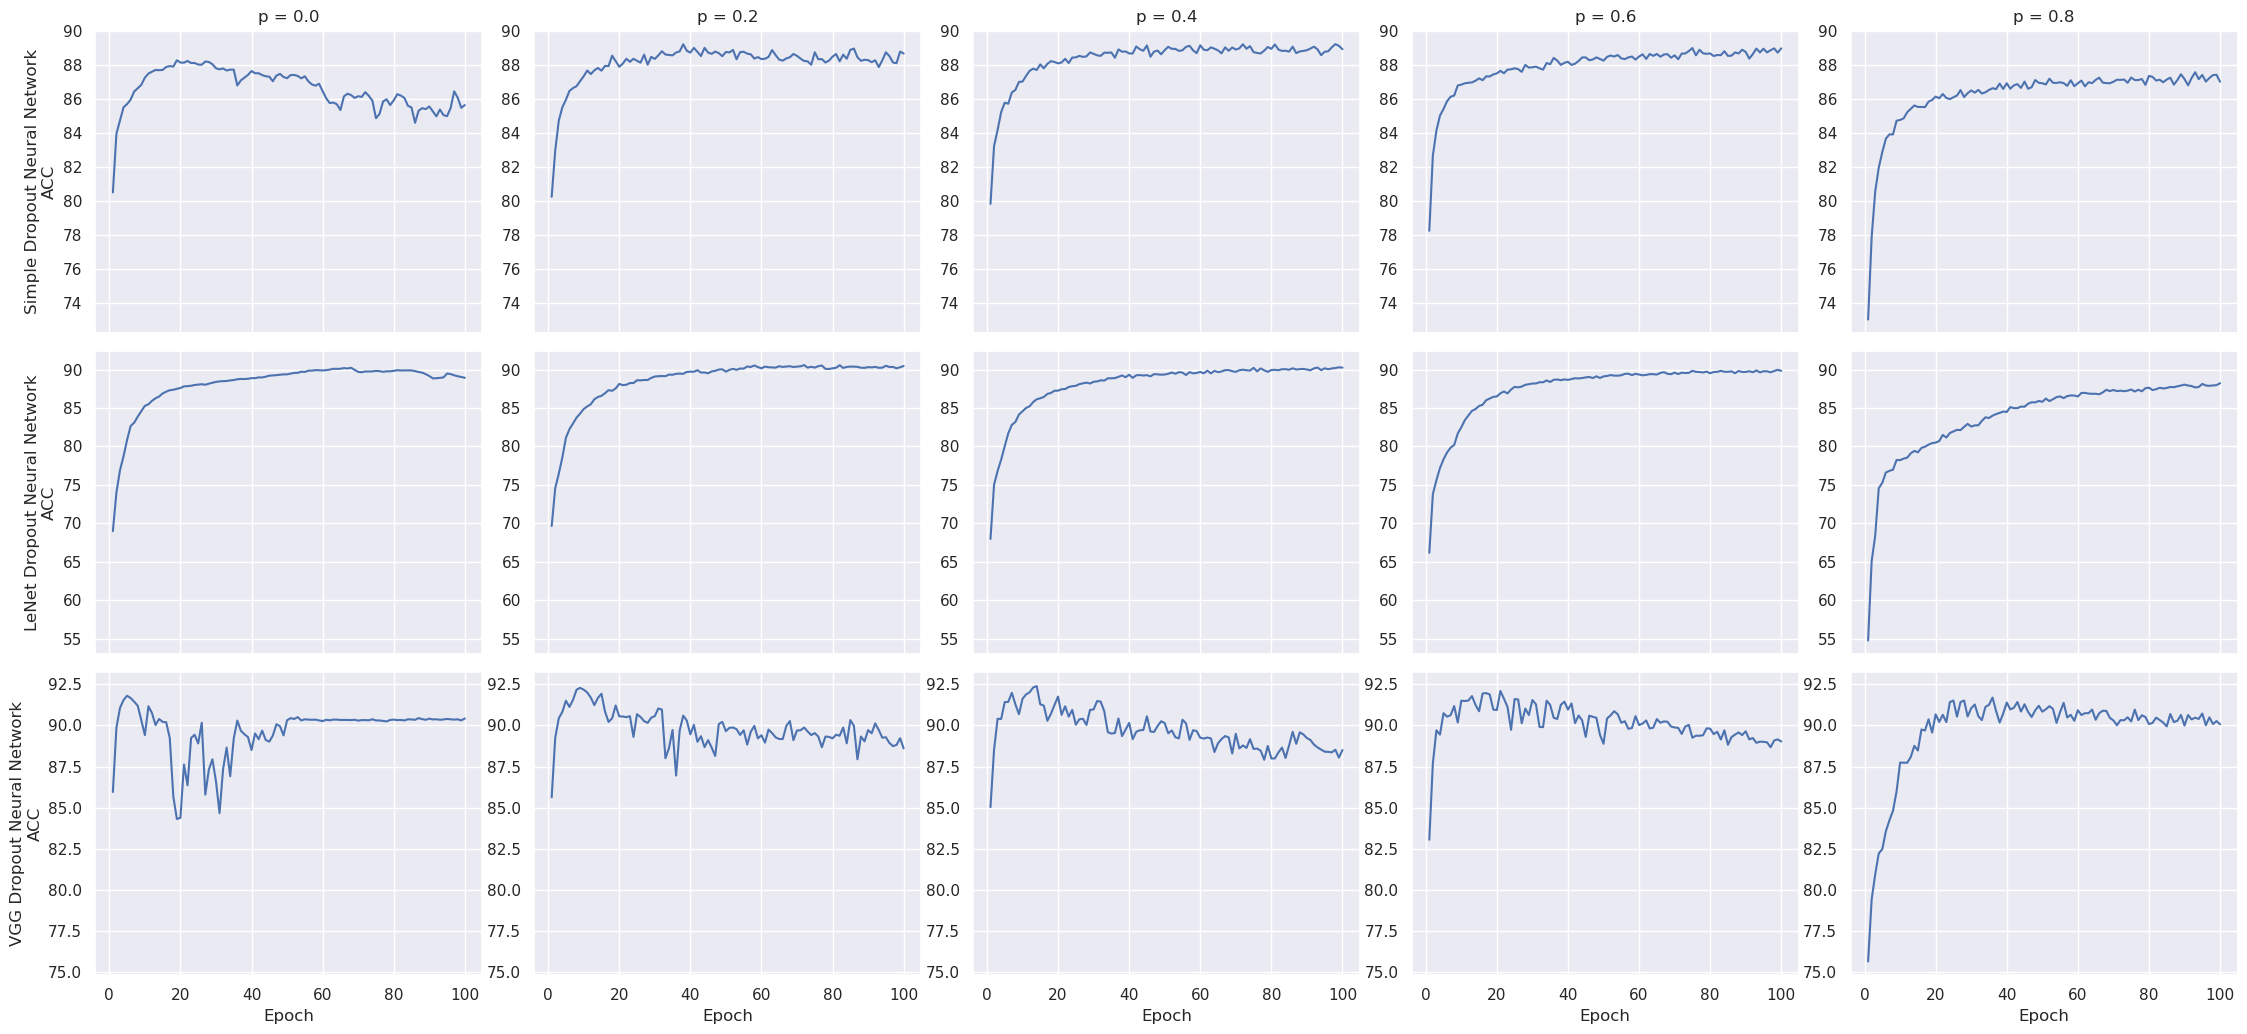

In [29]:
plot_dropout_histories(results, metric="acc")

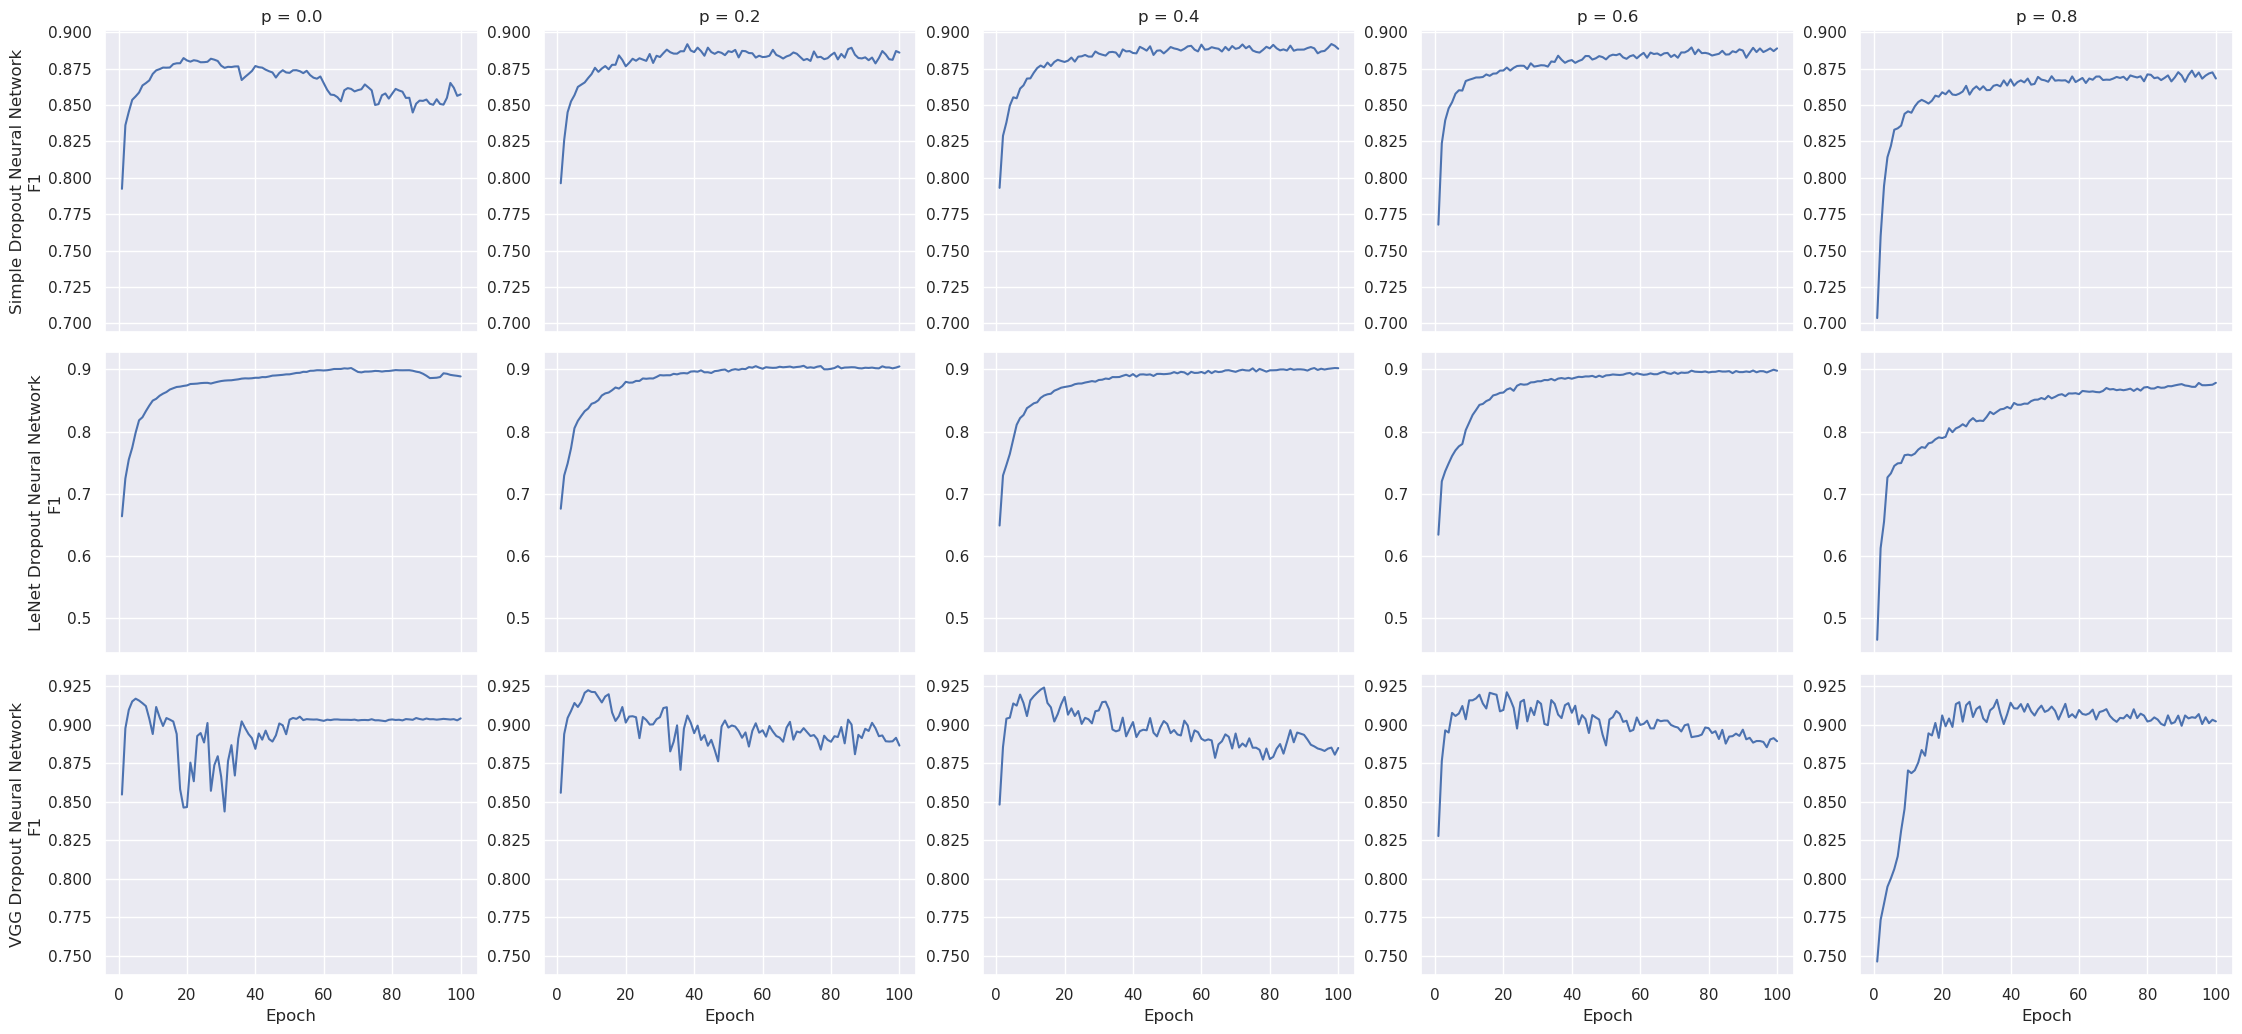

In [30]:
plot_dropout_histories(results, metric="f1")

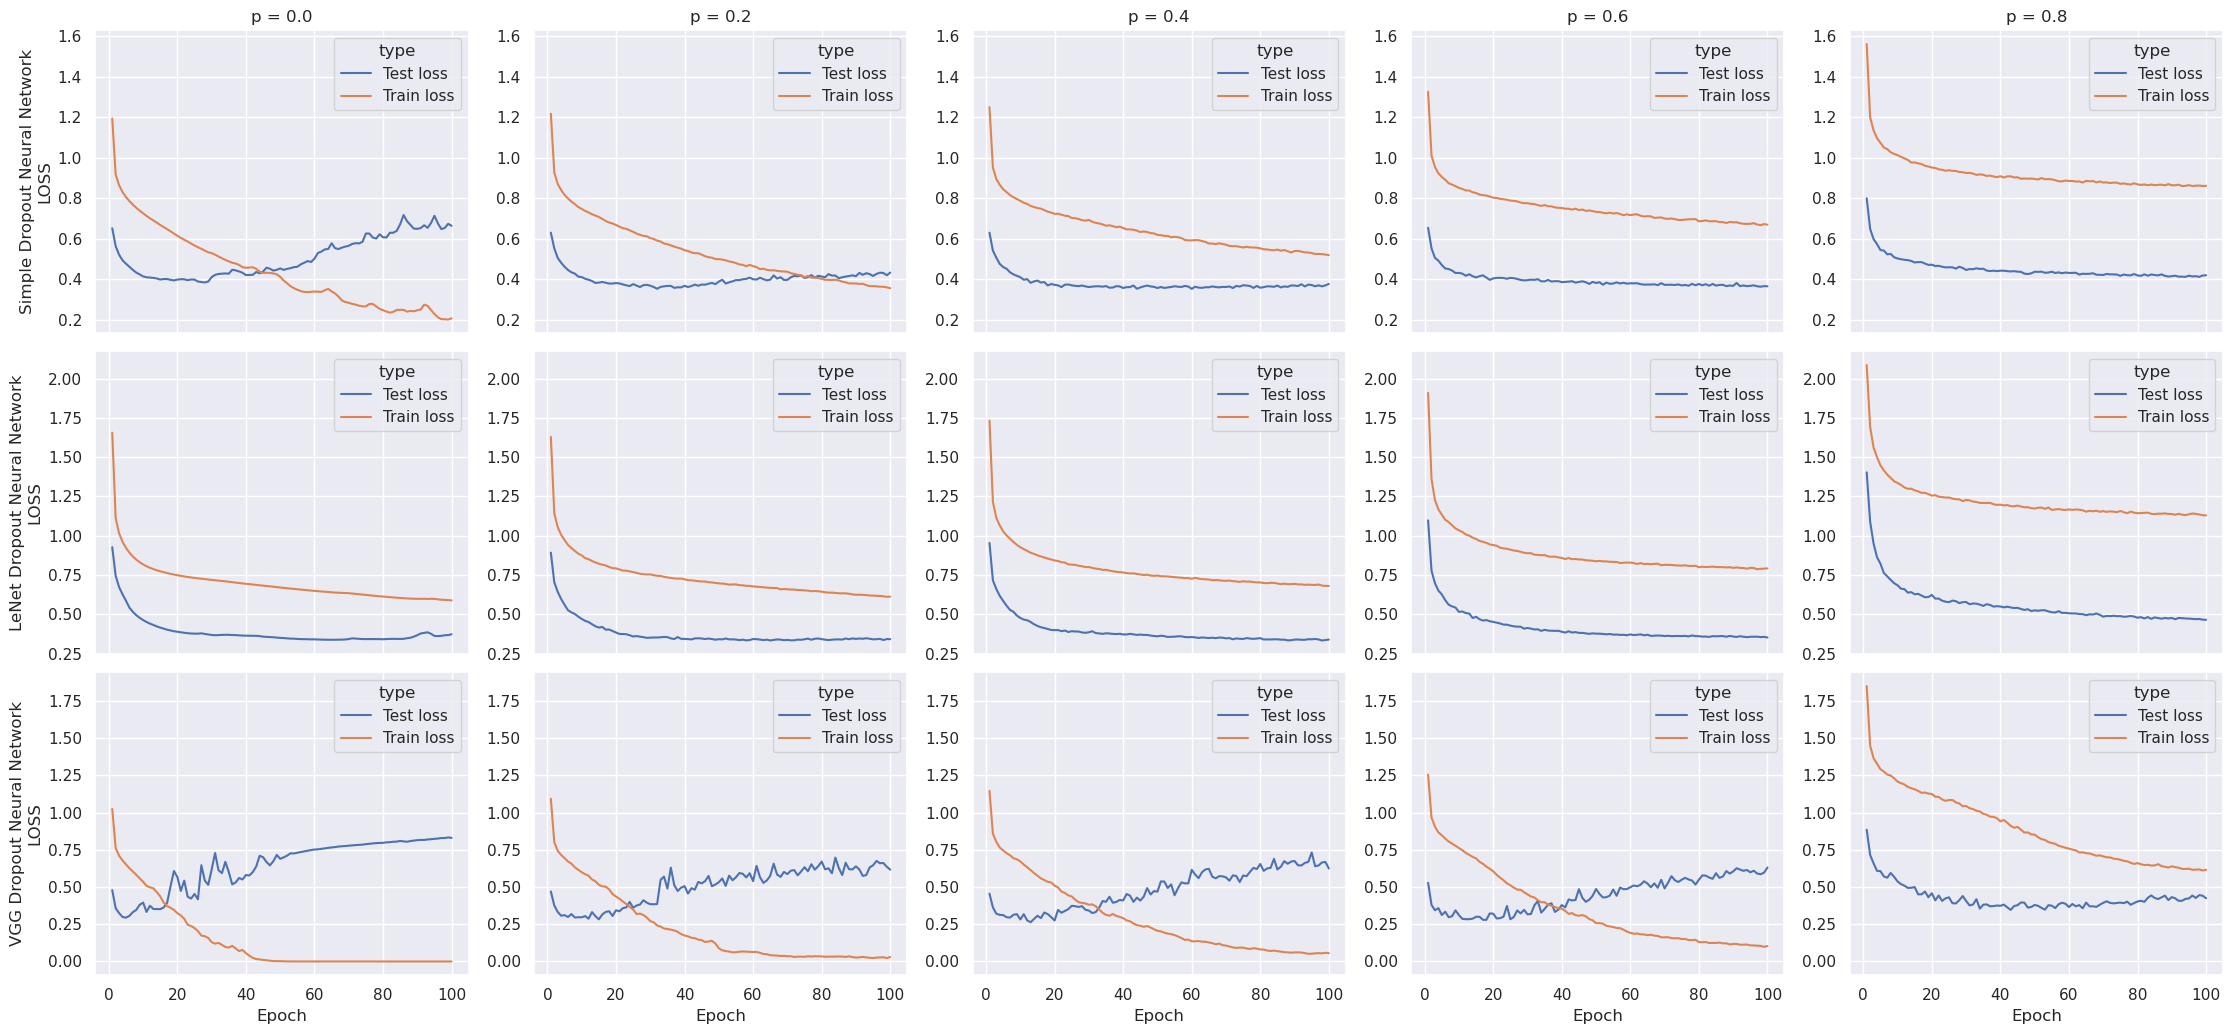

In [31]:
plot_dropout_histories(results, metric="loss")

## Monte Carlo Model Averaging

In [32]:
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [33]:
n_mc_samples = 100
mc_results = {}

print(f"{'='*80}")
print(f"MONTE CARLO DROPOUT AVERAGING - {n_mc_samples} samples")
print(f"{'='*80}\n")

for model_name in saved_models.keys():
    mc_results[model_name] = {}
    
    for p in dropout_rates:
        if p == 0.0:
            print(f"[SKIP] {model_name} | p={p} (no dropout)")
            continue
            
        print(f"\n{'='*60}")
        print(f"Model: {model_name}")
        print(f"Dropout rate: p={p}")
        print(f"MC samples: {n_mc_samples}")
        print(f"{'='*60}")
        
        model = saved_models[model_name][p]
        results = evaluate_mc_dropout(model, test_loader, n_samples=n_mc_samples, device=device)
        
        mc_results[model_name][p] = results
        
        print(f"Accuracy (MC Averaging): {results['accuracy']:.4f}")
        print(f"Uncertainty média: {results['uncertainties'].mean():.4f}")
        print(f"Uncertainty std: {results['uncertainties'].std():.4f}")
        print(f"Uncertainty min: {results['uncertainties'].min():.4f}")
        print(f"Uncertainty max: {results['uncertainties'].max():.4f}")

MONTE CARLO DROPOUT AVERAGING - 100 samples

[SKIP] Simple Dropout Neural Network | p=0.0 (no dropout)

Model: Simple Dropout Neural Network
Dropout rate: p=0.2
MC samples: 100
Accuracy (MC Averaging): 0.8951
Uncertainty média: 0.1945
Uncertainty std: 0.3055
Uncertainty min: 0.0000
Uncertainty max: 1.7673

Model: Simple Dropout Neural Network
Dropout rate: p=0.4
MC samples: 100
Accuracy (MC Averaging): 0.8956
Uncertainty média: 0.2471
Uncertainty std: 0.3437
Uncertainty min: 0.0000
Uncertainty max: 1.8734

Model: Simple Dropout Neural Network
Dropout rate: p=0.6
MC samples: 100
Accuracy (MC Averaging): 0.8916
Uncertainty média: 0.3275
Uncertainty std: 0.3922
Uncertainty min: 0.0000
Uncertainty max: 1.9619

Model: Simple Dropout Neural Network
Dropout rate: p=0.8
MC samples: 100
Accuracy (MC Averaging): 0.8740
Uncertainty média: 0.5202
Uncertainty std: 0.4494
Uncertainty min: 0.0007
Uncertainty max: 2.2094
[SKIP] LeNet Dropout Neural Network | p=0.0 (no dropout)

Model: LeNet Dropout Ne

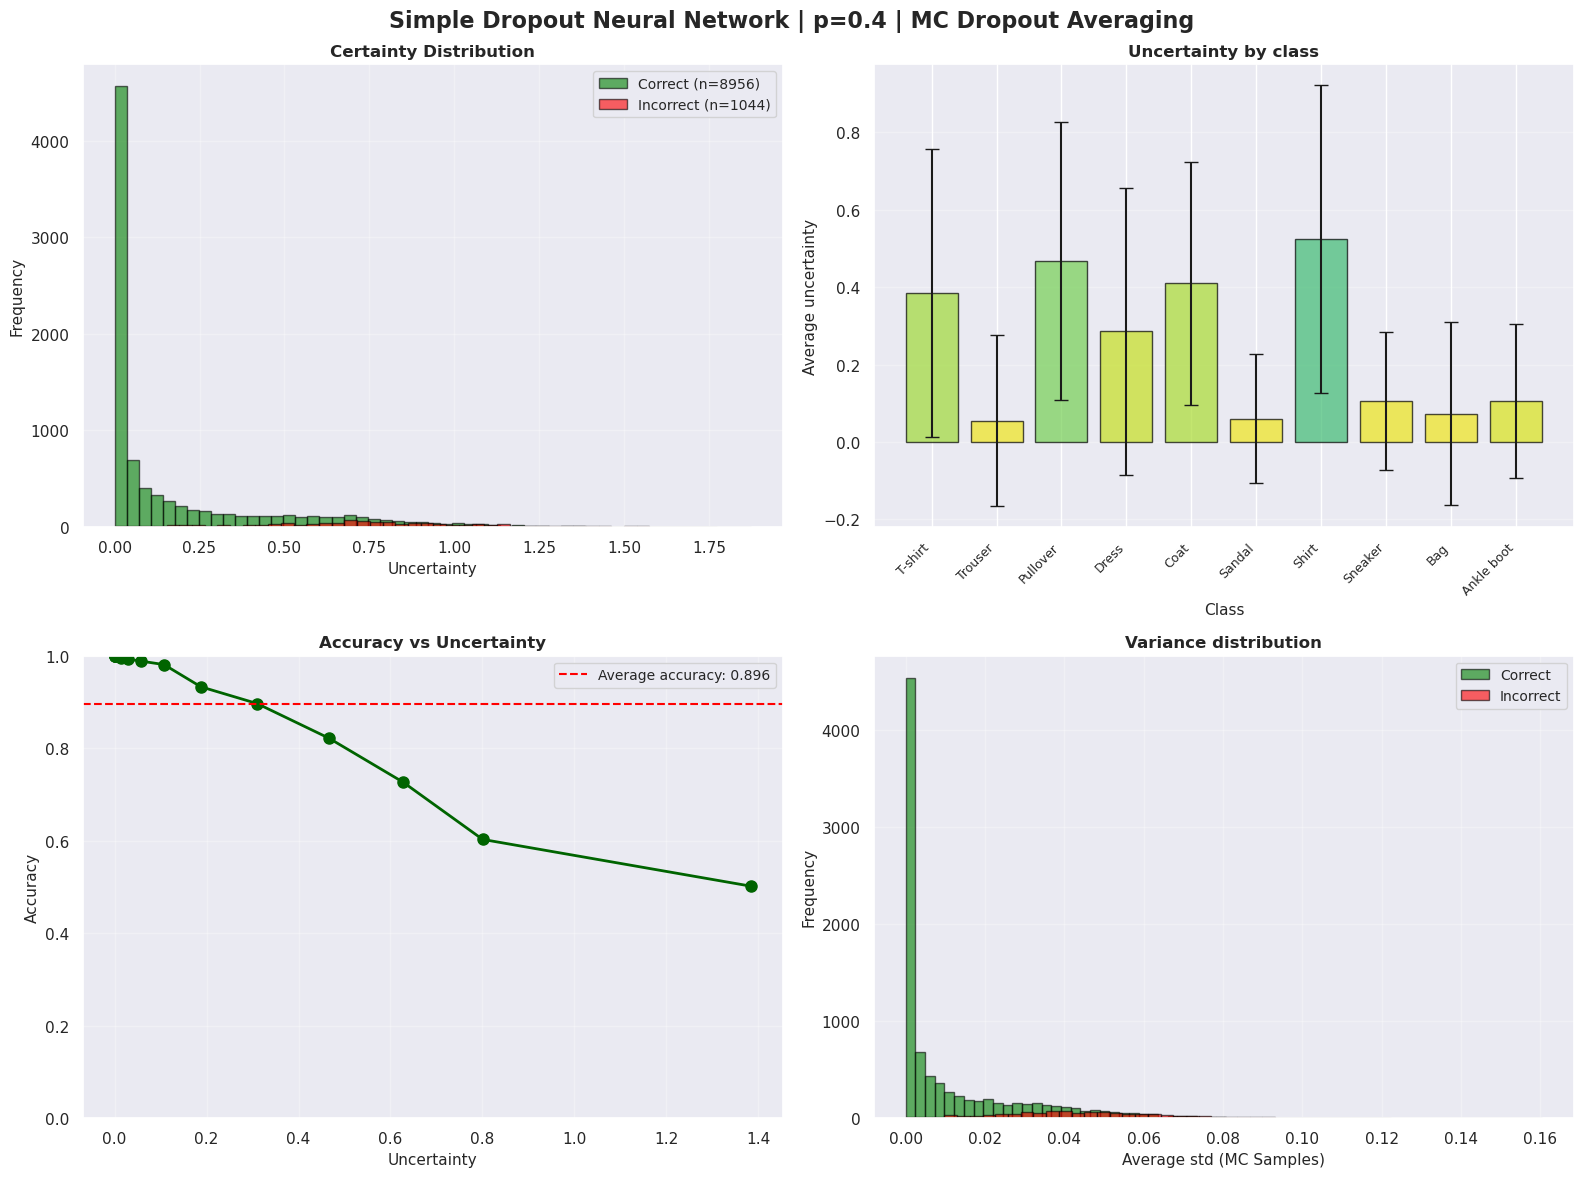


STATISTICS - Simple Dropout Neural Network | p=0.4
Accuracy MC Dropout: 0.8956
Correct predictions: 8956/10000 (89.56%)

Uncertainty (Entropy):
  Average (correct): 0.1868
  Average (incorrect): 0.7644
  Difference: 0.5776

Desvio Padrão MC:
  Average (correct): 0.0115
  Average (incorrect): 0.0452


In [34]:
plot_mc_uncertainty_analysis(mc_results, 'Simple Dropout Neural Network', 0.4, class_names=class_names)

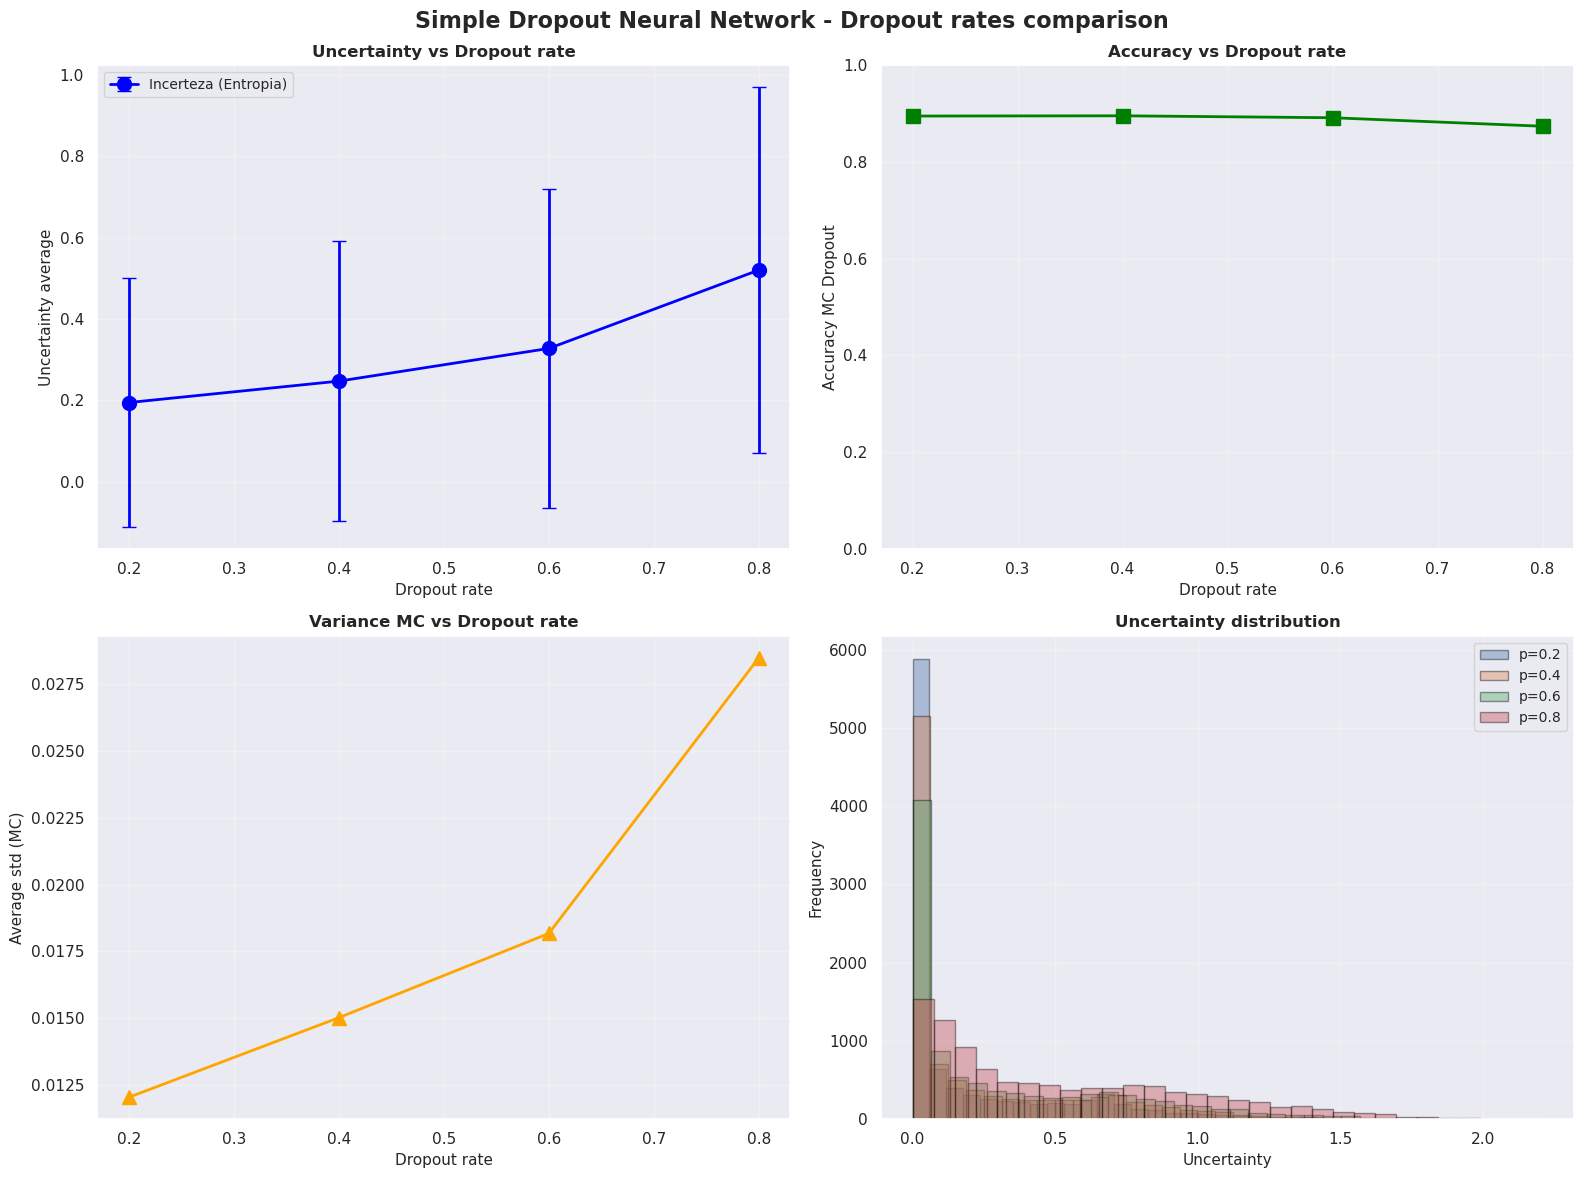

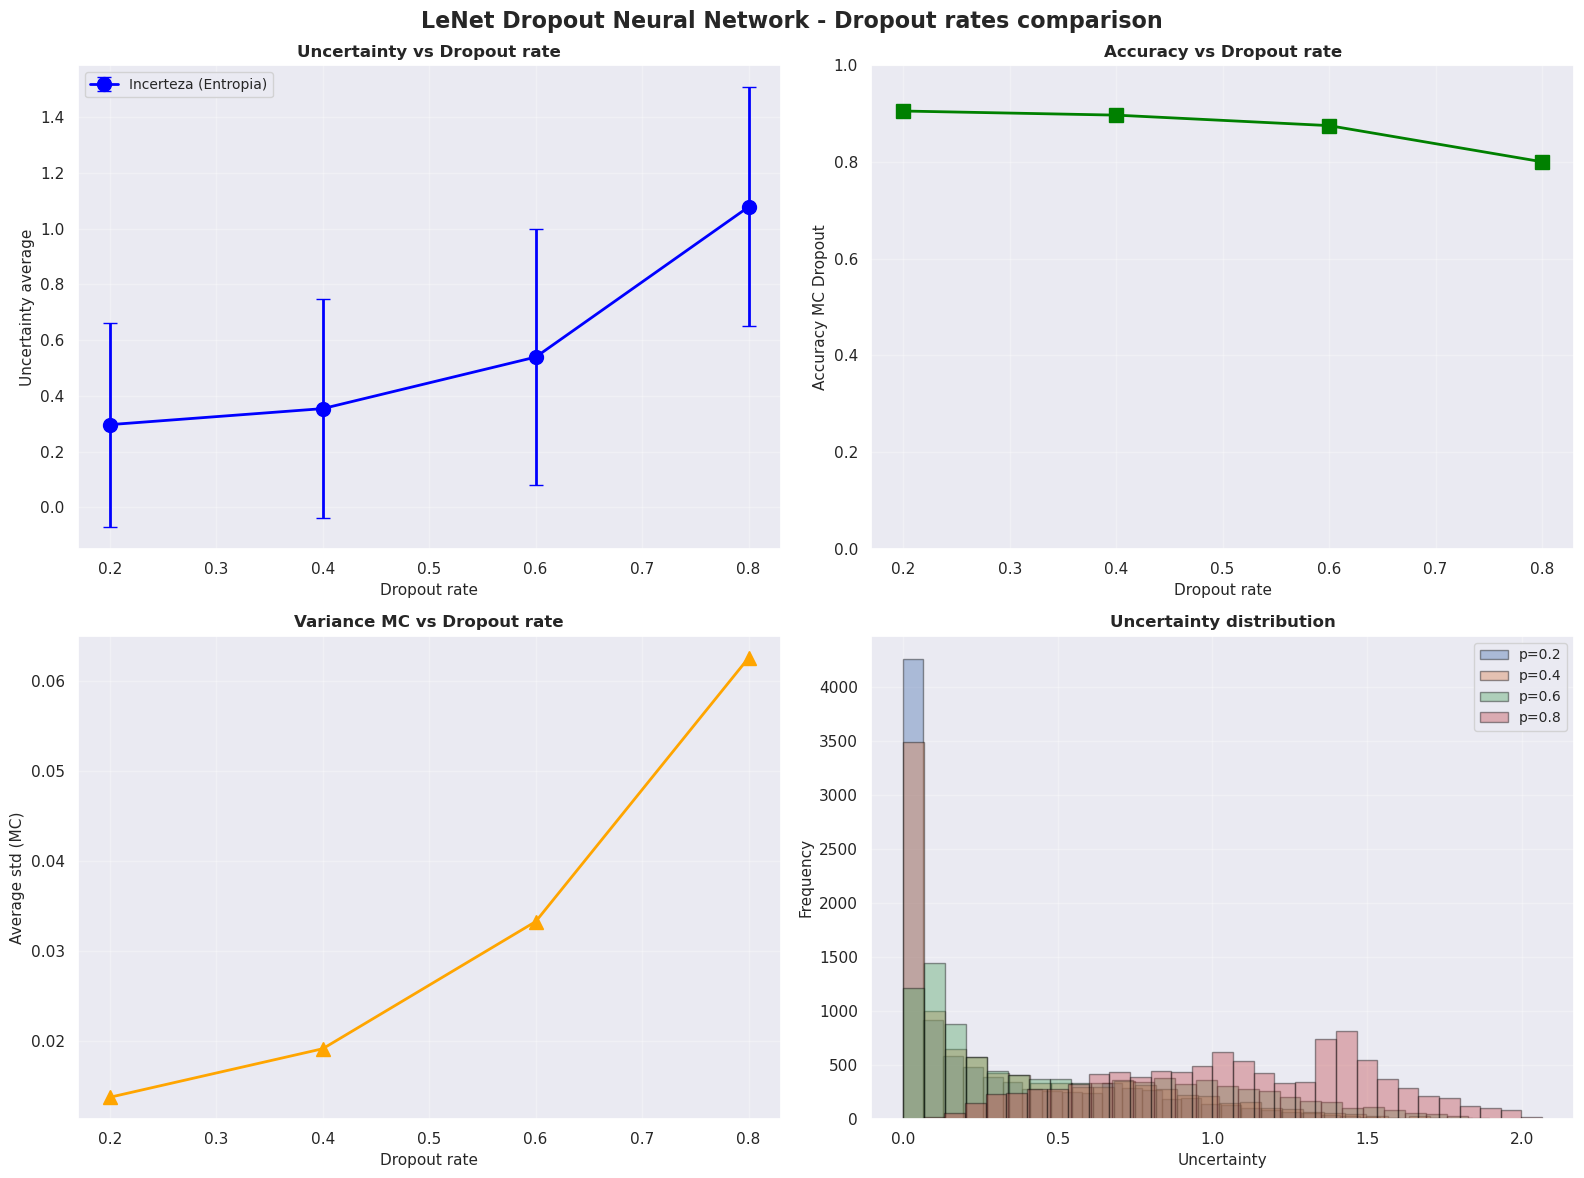

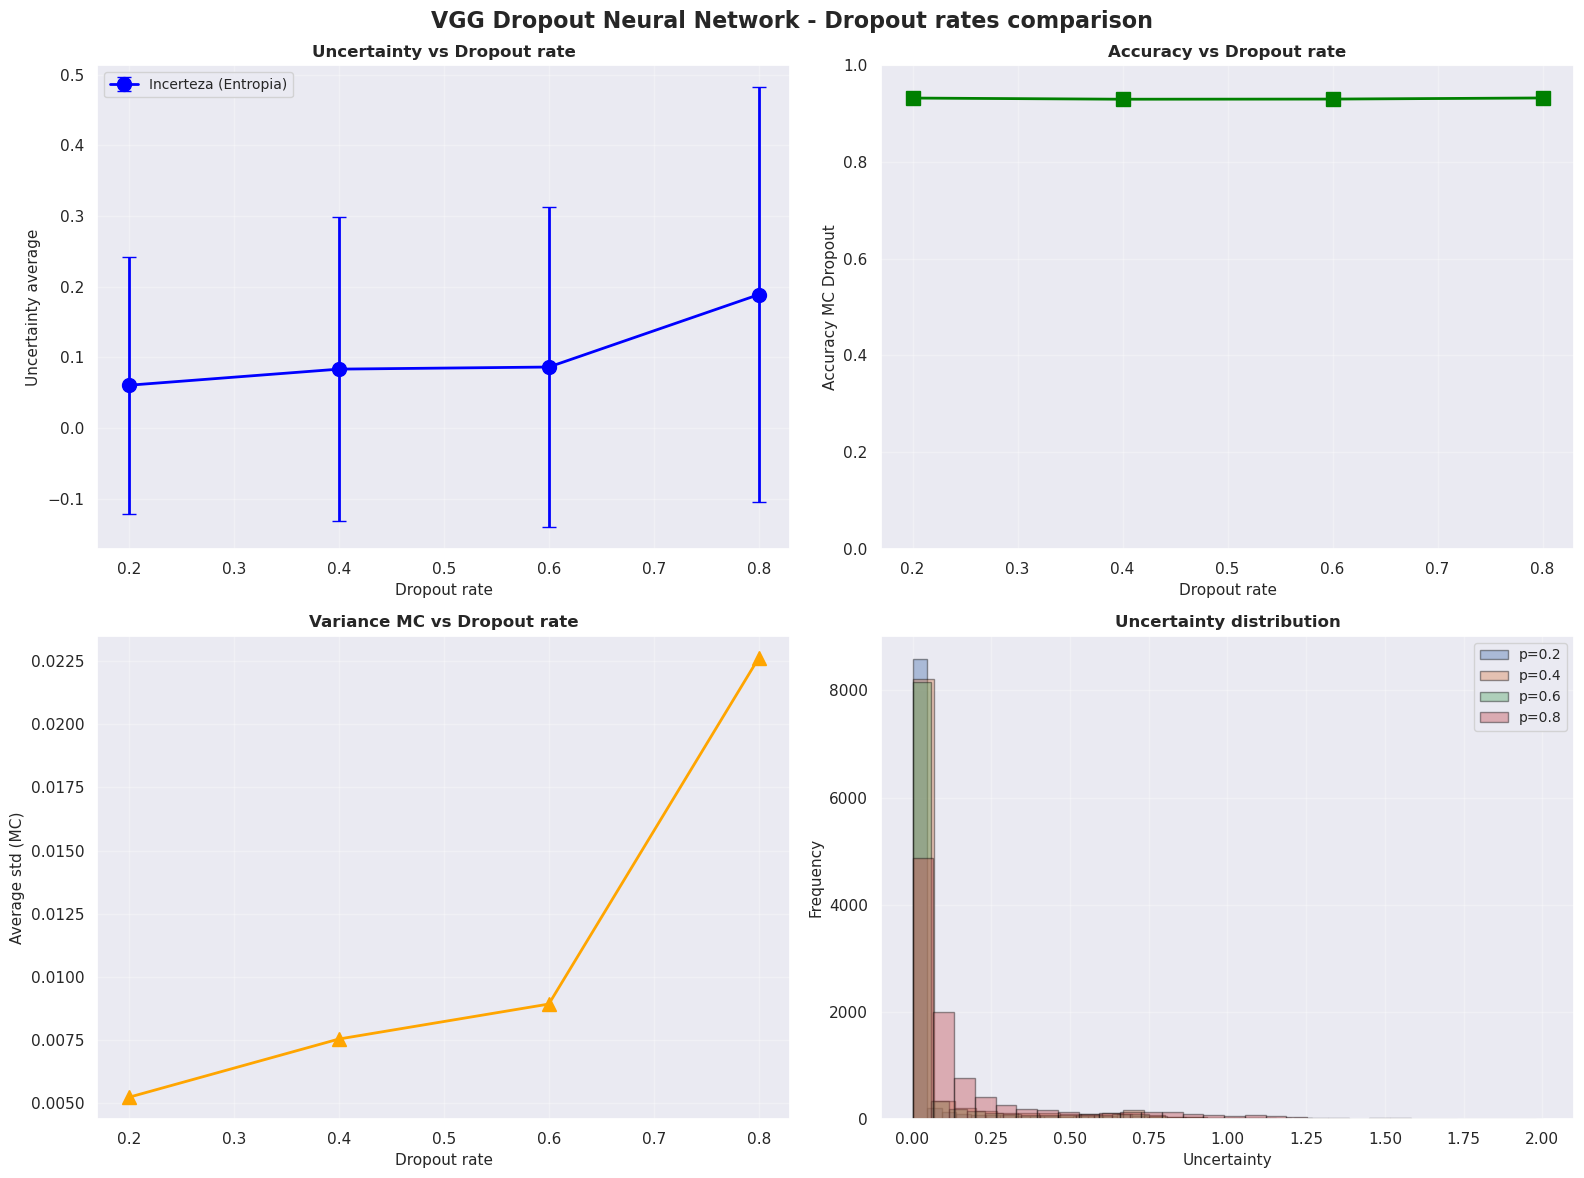

In [35]:
for model_name in mc_results.keys():
    compare_dropout_rates_mc(mc_results, model_name, dropout_rates=dropout_rates)

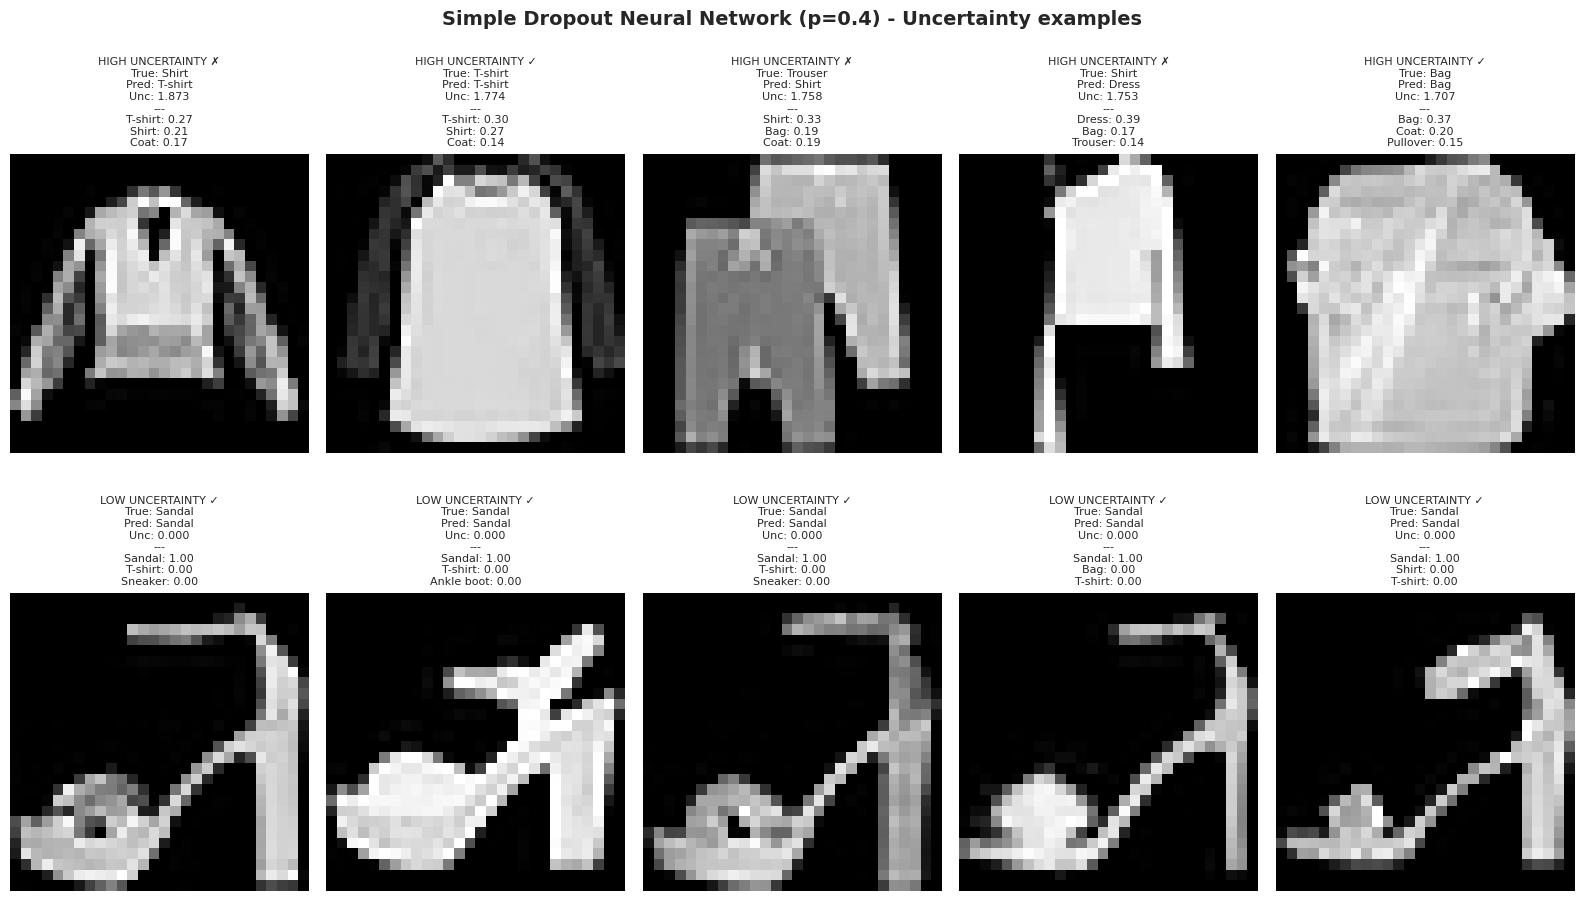

In [36]:
visualize_uncertainty_examples(mc_results, 'Simple Dropout Neural Network', 0.4, test, class_names, n_examples=5)

In [37]:
summary_df = create_mc_summary_table(mc_results)
print("\n" + "="*100)
print("RESUMO - MONTE CARLO DROPOUT AVERAGING")
print("="*100)
print(summary_df.to_string(index=False))


RESUMO - MONTE CARLO DROPOUT AVERAGING
                        Model  Dropout Rate Accuracy Mean Uncertainty Std Uncertainty Unc (Correct) Unc (Incorrect) Unc Delta
Simple Dropout Neural Network        0.2000   0.8951           0.1945          0.3055        0.1394          0.6646    0.5253
Simple Dropout Neural Network        0.4000   0.8956           0.2471          0.3437        0.1868          0.7644    0.5776
Simple Dropout Neural Network        0.6000   0.8916           0.3275          0.3922        0.2593          0.8887    0.6295
Simple Dropout Neural Network        0.8000   0.8740           0.5202          0.4494        0.4415          1.0663    0.6248
 LeNet Dropout Neural Network        0.2000   0.9055           0.2965          0.3667        0.2386          0.8513    0.6126
 LeNet Dropout Neural Network        0.4000   0.8970           0.3540          0.3931        0.2881          0.9281    0.6399
 LeNet Dropout Neural Network        0.6000   0.8753           0.5392         

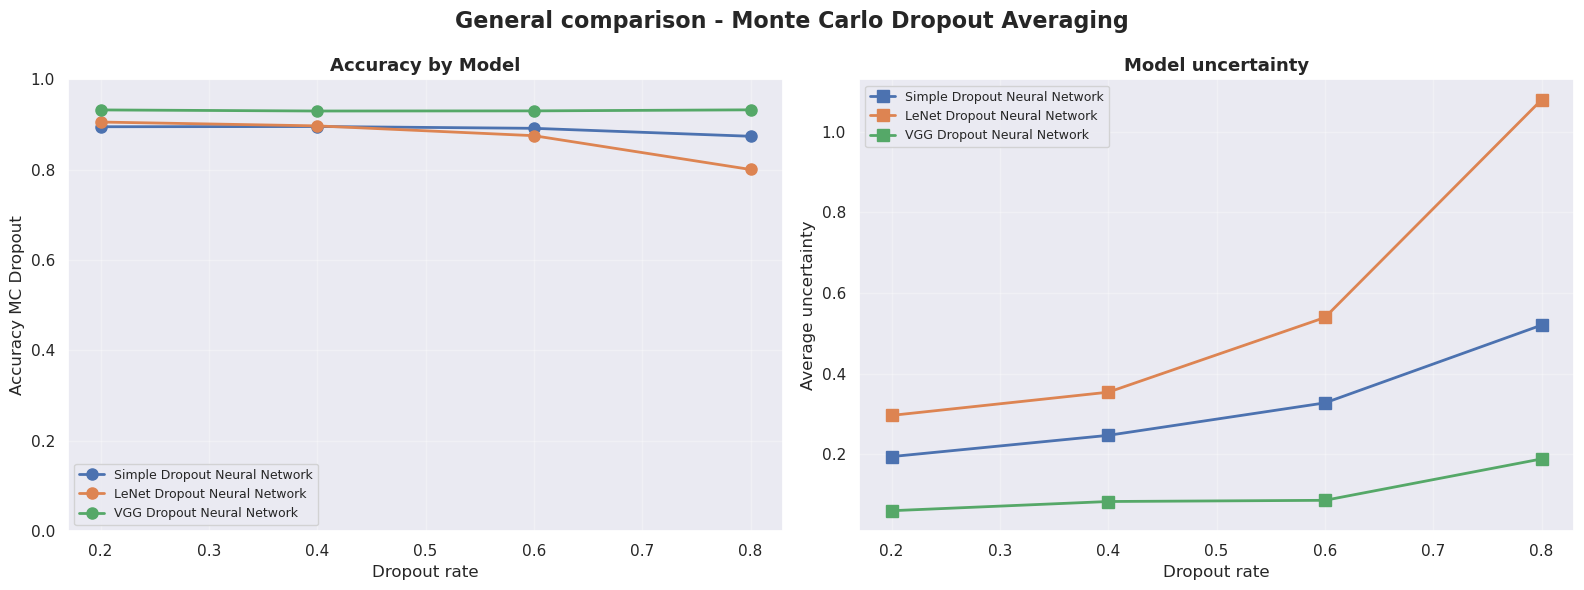

In [38]:
compare_all_models_mc(mc_results)